In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras.optimizers import RMSprop
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/train.csv')

In [3]:
df_train.head(10)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
6,002be4f.jpg_Gravel,NaN
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...


In [4]:
df_label_split = df_train['Image_Label'].str.split('_', expand = True)
df_label_split.columns = ["Filename", "ClassId"]
df_label_split.head()

,Filename,ClassId
0,0011165.jpg,Fish
1,0011165.jpg,Flower
2,0011165.jpg,Gravel
3,0011165.jpg,Sugar
4,002be4f.jpg,Fish


In [5]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train = df_train[['Image_Label', 'Defect','EncodedPixels']]
df_train.head()

,Image_Label,Defect,EncodedPixels
0,0011165.jpg_Fish,True,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,True,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,False,NaN
3,0011165.jpg_Sugar,False,NaN
4,002be4f.jpg_Fish,True,233813 878 235213 878 236613 878 238010 881 23...


In [6]:
df_train = pd.concat([df_train, df_label_split], axis=1, sort=False)
df_train = df_train.drop(['Image_Label'], axis=1)
df_train.head()

,Defect,EncodedPixels,Filename,ClassId
0,True,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,True,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,False,NaN,0011165.jpg,Gravel
3,False,NaN,0011165.jpg,Sugar
4,True,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [7]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)
df_train = df_train[['Filename', 'ClassId', 'EncodedPixels']]
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,Sugar,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,Flower,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,Gravel,65400 380 66800 380 68200 380 69600 380 71000 ...


In [8]:
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()
df_train['ClassId'] = le.fit_transform(df_train['ClassId'])

In [9]:
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,0,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,1,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,0,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,1,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,3,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,1,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,3,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,1,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,2,65400 380 66800 380 68200 380 69600 380 71000 ...


### Utility functions

In [10]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [11]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Model in Keras

In [12]:
ORIG_IMG_SIZE_HEIGHT = 1400
ORIG_IMG_SIZE_WIDTH = 2100
TRAIN_IMG_SIZE_HEIGHT = 352
TRAIN_IMG_SIZE_WIDTH = 544

BATCH_SIZE = 6

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 3


In [13]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V1(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, 
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['Filename'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,(int(self.df['ClassId'].iloc[indexes[idx]]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        
        X_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        
        (X_list, y_list) = zip(image_generator, mask_generator).__next__()
        for i in range(len(X_list)):
            X_arg[i,] = X[i,]
            y_arg[i,:,:,:] = y[i,:,:,:]
            X_arg[i + self.batch_size] = X_list[i]
            y_arg[i + self.batch_size] = y_list[i]

        return X_arg, y_arg

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [15]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def unet_352x544_segmentation_model(input_shape=(352, 544, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    down_1 = Conv2D(16, (3, 3), padding='same')(inputs)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1 = Conv2D(16, (3, 3), padding='same')(down_1)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_1) # output 176, 272
    
    down0 = Conv2D(32, (3, 3), padding='same')(down_1_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 88, 136

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 44, 68

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 22, 34

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 11, 17

    center = Conv2D(1024, (3, 3), padding='same')(down3_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up3 = UpSampling2D((2, 2))(center)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) 

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)

    up_1 = UpSampling2D((2, 2))(up0)
    up_1 = concatenate([down_1, up_1], axis=3)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up_1)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [16]:
model_352x544 = unet_352x544_segmentation_model(num_classes=4)
model_352x544.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])
model_352x544.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 352, 544, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 544, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 544, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 352, 544, 16) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 11, 17, 1024) 0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 11, 17, 1024) 9438208     activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 11, 17, 1024) 4096        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 11, 17, 1024) 0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 22, 34, 1024) 0           activation_12[0][0]              
__________________________________________________________________________________________________
concatenat

conv2d_22 (Conv2D)              (None, 176, 272, 32) 27680       concatenate_4[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 176, 272, 32) 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 176, 272, 32) 0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 176, 272, 32) 9248        activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 176, 272, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation

#### Training

In [25]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./unet_model_350x525_4classes_V2.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [19]:
idx = int(0.8*len(df_train))
dataGen_train = ImgDataGenerator_V1(df_train.iloc[:idx], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V1(df_train.iloc[idx:], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history = model_352x544.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3


 130/1578 [=>............................] - ETA: 10:12:13 - loss: 0.0594 - dice_coeff: 0.1403 - acc: 0.48 - ETA: 5:14:24 - loss: 0.0497 - dice_coeff: 0.1409 - acc: 0.5077 - ETA: 3:35:12 - loss: 0.0800 - dice_coeff: 0.1216 - acc: 0.497 - ETA: 2:45:33 - loss: 0.0819 - dice_coeff: 0.1182 - acc: 0.512 - ETA: 2:15:47 - loss: 0.0699 - dice_coeff: 0.1218 - acc: 0.524 - ETA: 1:55:54 - loss: 0.0699 - dice_coeff: 0.1195 - acc: 0.547 - ETA: 1:41:43 - loss: 0.0738 - dice_coeff: 0.1168 - acc: 0.550 - ETA: 1:31:04 - loss: 0.0786 - dice_coeff: 0.1130 - acc: 0.565 - ETA: 1:22:47 - loss: 0.0708 - dice_coeff: 0.1157 - acc: 0.572 - ETA: 1:16:07 - loss: 0.0752 - dice_coeff: 0.1130 - acc: 0.575 - ETA: 1:10:43 - loss: 0.0709 - dice_coeff: 0.1141 - acc: 0.586 - ETA: 1:06:11 - loss: 0.0753 - dice_coeff: 0.1110 - acc: 0.591 - ETA: 1:04:10 - loss: 0.0651 - dice_coeff: 0.1156 - acc: 0.586 - ETA: 1:02:43 - loss: 0.0633 - dice_coeff: 0.1164 - acc: 0.580 - ETA: 1:01:28 - loss: 0.0560 - dice_coeff: 0.1198 - acc: 0.

 262/1578 [===>..........................] - ETA: 43:08 - loss: -0.0101 - dice_coeff: 0.1318 - acc: 0.55 - ETA: 43:05 - loss: -0.0106 - dice_coeff: 0.1320 - acc: 0.55 - ETA: 43:03 - loss: -0.0116 - dice_coeff: 0.1324 - acc: 0.55 - ETA: 43:00 - loss: -0.0112 - dice_coeff: 0.1321 - acc: 0.55 - ETA: 42:58 - loss: -0.0111 - dice_coeff: 0.1321 - acc: 0.55 - ETA: 42:55 - loss: -0.0110 - dice_coeff: 0.1319 - acc: 0.55 - ETA: 42:52 - loss: -0.0112 - dice_coeff: 0.1319 - acc: 0.55 - ETA: 42:50 - loss: -0.0111 - dice_coeff: 0.1318 - acc: 0.55 - ETA: 42:48 - loss: -0.0117 - dice_coeff: 0.1320 - acc: 0.55 - ETA: 42:45 - loss: -0.0114 - dice_coeff: 0.1318 - acc: 0.55 - ETA: 42:43 - loss: -0.0120 - dice_coeff: 0.1320 - acc: 0.54 - ETA: 42:40 - loss: -0.0115 - dice_coeff: 0.1317 - acc: 0.54 - ETA: 42:37 - loss: -0.0116 - dice_coeff: 0.1317 - acc: 0.54 - ETA: 42:34 - loss: -0.0118 - dice_coeff: 0.1317 - acc: 0.54 - ETA: 42:31 - loss: -0.0121 - dice_coeff: 0.1317 - acc: 0.54 - ETA: 42:29 - loss: -0.013

 394/1578 [======>.......................] - ETA: 38:21 - loss: -0.0370 - dice_coeff: 0.1357 - acc: 0.54 - ETA: 38:19 - loss: -0.0370 - dice_coeff: 0.1356 - acc: 0.54 - ETA: 38:17 - loss: -0.0373 - dice_coeff: 0.1357 - acc: 0.54 - ETA: 38:15 - loss: -0.0371 - dice_coeff: 0.1356 - acc: 0.54 - ETA: 38:15 - loss: -0.0374 - dice_coeff: 0.1357 - acc: 0.53 - ETA: 38:15 - loss: -0.0377 - dice_coeff: 0.1357 - acc: 0.53 - ETA: 38:13 - loss: -0.0378 - dice_coeff: 0.1357 - acc: 0.54 - ETA: 38:11 - loss: -0.0384 - dice_coeff: 0.1359 - acc: 0.53 - ETA: 38:09 - loss: -0.0385 - dice_coeff: 0.1360 - acc: 0.53 - ETA: 38:07 - loss: -0.0384 - dice_coeff: 0.1358 - acc: 0.53 - ETA: 38:05 - loss: -0.0390 - dice_coeff: 0.1361 - acc: 0.53 - ETA: 38:03 - loss: -0.0391 - dice_coeff: 0.1361 - acc: 0.53 - ETA: 38:02 - loss: -0.0395 - dice_coeff: 0.1362 - acc: 0.53 - ETA: 38:00 - loss: -0.0405 - dice_coeff: 0.1366 - acc: 0.54 - ETA: 37:57 - loss: -0.0403 - dice_coeff: 0.1365 - acc: 0.54 - ETA: 37:55 - loss: -0.040

 526/1578 [=========>....................] - ETA: 34:14 - loss: -0.0530 - dice_coeff: 0.1367 - acc: 0.52 - ETA: 34:12 - loss: -0.0534 - dice_coeff: 0.1368 - acc: 0.52 - ETA: 34:10 - loss: -0.0536 - dice_coeff: 0.1368 - acc: 0.52 - ETA: 34:08 - loss: -0.0539 - dice_coeff: 0.1369 - acc: 0.52 - ETA: 34:07 - loss: -0.0540 - dice_coeff: 0.1369 - acc: 0.52 - ETA: 34:05 - loss: -0.0542 - dice_coeff: 0.1370 - acc: 0.52 - ETA: 34:03 - loss: -0.0549 - dice_coeff: 0.1373 - acc: 0.52 - ETA: 34:01 - loss: -0.0554 - dice_coeff: 0.1375 - acc: 0.52 - ETA: 33:59 - loss: -0.0556 - dice_coeff: 0.1376 - acc: 0.52 - ETA: 33:57 - loss: -0.0557 - dice_coeff: 0.1376 - acc: 0.52 - ETA: 33:55 - loss: -0.0557 - dice_coeff: 0.1376 - acc: 0.52 - ETA: 33:53 - loss: -0.0557 - dice_coeff: 0.1375 - acc: 0.52 - ETA: 33:51 - loss: -0.0557 - dice_coeff: 0.1375 - acc: 0.52 - ETA: 33:49 - loss: -0.0559 - dice_coeff: 0.1375 - acc: 0.52 - ETA: 33:48 - loss: -0.0558 - dice_coeff: 0.1374 - acc: 0.52 - ETA: 33:46 - loss: -0.056

 658/1578 [===========>..................] - ETA: 30:14 - loss: -0.0706 - dice_coeff: 0.1402 - acc: 0.50 - ETA: 30:12 - loss: -0.0707 - dice_coeff: 0.1402 - acc: 0.49 - ETA: 30:10 - loss: -0.0707 - dice_coeff: 0.1401 - acc: 0.49 - ETA: 30:08 - loss: -0.0709 - dice_coeff: 0.1402 - acc: 0.49 - ETA: 30:06 - loss: -0.0710 - dice_coeff: 0.1402 - acc: 0.49 - ETA: 30:04 - loss: -0.0714 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 30:03 - loss: -0.0715 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 30:01 - loss: -0.0715 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 29:59 - loss: -0.0717 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 29:57 - loss: -0.0719 - dice_coeff: 0.1405 - acc: 0.49 - ETA: 29:56 - loss: -0.0720 - dice_coeff: 0.1405 - acc: 0.49 - ETA: 29:54 - loss: -0.0719 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 29:52 - loss: -0.0718 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 29:50 - loss: -0.0719 - dice_coeff: 0.1404 - acc: 0.49 - ETA: 29:48 - loss: -0.0719 - dice_coeff: 0.1403 - acc: 0.49 - ETA: 29:47 - loss: -0.072

 790/1578 [==============>...............] - ETA: 26:22 - loss: -0.0861 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:20 - loss: -0.0861 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:18 - loss: -0.0863 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:16 - loss: -0.0863 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:15 - loss: -0.0863 - dice_coeff: 0.1439 - acc: 0.47 - ETA: 26:13 - loss: -0.0864 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:11 - loss: -0.0864 - dice_coeff: 0.1439 - acc: 0.47 - ETA: 26:09 - loss: -0.0866 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:08 - loss: -0.0867 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:06 - loss: -0.0868 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:04 - loss: -0.0868 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:02 - loss: -0.0869 - dice_coeff: 0.1440 - acc: 0.47 - ETA: 26:00 - loss: -0.0873 - dice_coeff: 0.1441 - acc: 0.47 - ETA: 25:59 - loss: -0.0875 - dice_coeff: 0.1442 - acc: 0.47 - ETA: 25:57 - loss: -0.0877 - dice_coeff: 0.1443 - acc: 0.47 - ETA: 25:55 - loss: -0.087

 922/1578 [================>.............] - ETA: 22:31 - loss: -0.0996 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:29 - loss: -0.0997 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:27 - loss: -0.0998 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:26 - loss: -0.0998 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:24 - loss: -0.0998 - dice_coeff: 0.1474 - acc: 0.45 - ETA: 22:22 - loss: -0.0998 - dice_coeff: 0.1474 - acc: 0.45 - ETA: 22:20 - loss: -0.1000 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:19 - loss: -0.1001 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:17 - loss: -0.1001 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:15 - loss: -0.1002 - dice_coeff: 0.1475 - acc: 0.45 - ETA: 22:14 - loss: -0.1004 - dice_coeff: 0.1476 - acc: 0.45 - ETA: 22:12 - loss: -0.1004 - dice_coeff: 0.1476 - acc: 0.45 - ETA: 22:10 - loss: -0.1006 - dice_coeff: 0.1476 - acc: 0.45 - ETA: 22:08 - loss: -0.1006 - dice_coeff: 0.1477 - acc: 0.45 - ETA: 22:07 - loss: -0.1007 - dice_coeff: 0.1477 - acc: 0.45 - ETA: 22:05 - loss: -0.100

1054/1578 [===================>..........] - ETA: 18:43 - loss: -0.1096 - dice_coeff: 0.1497 - acc: 0.43 - ETA: 18:41 - loss: -0.1097 - dice_coeff: 0.1497 - acc: 0.43 - ETA: 18:39 - loss: -0.1099 - dice_coeff: 0.1498 - acc: 0.43 - ETA: 18:37 - loss: -0.1100 - dice_coeff: 0.1498 - acc: 0.43 - ETA: 18:36 - loss: -0.1101 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:34 - loss: -0.1102 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:32 - loss: -0.1102 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:31 - loss: -0.1103 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:29 - loss: -0.1103 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:27 - loss: -0.1103 - dice_coeff: 0.1499 - acc: 0.43 - ETA: 18:25 - loss: -0.1105 - dice_coeff: 0.1500 - acc: 0.43 - ETA: 18:23 - loss: -0.1106 - dice_coeff: 0.1500 - acc: 0.43 - ETA: 18:22 - loss: -0.1106 - dice_coeff: 0.1500 - acc: 0.43 - ETA: 18:20 - loss: -0.1107 - dice_coeff: 0.1500 - acc: 0.43 - ETA: 18:18 - loss: -0.1108 - dice_coeff: 0.1501 - acc: 0.43 - ETA: 18:17 - loss: -0.110

1186/1578 [=====================>........] - ETA: 14:54 - loss: -0.1194 - dice_coeff: 0.1523 - acc: 0.42 - ETA: 14:53 - loss: -0.1194 - dice_coeff: 0.1523 - acc: 0.42 - ETA: 14:51 - loss: -0.1195 - dice_coeff: 0.1524 - acc: 0.42 - ETA: 14:49 - loss: -0.1196 - dice_coeff: 0.1524 - acc: 0.42 - ETA: 14:47 - loss: -0.1197 - dice_coeff: 0.1524 - acc: 0.42 - ETA: 14:46 - loss: -0.1197 - dice_coeff: 0.1524 - acc: 0.42 - ETA: 14:44 - loss: -0.1198 - dice_coeff: 0.1524 - acc: 0.42 - ETA: 14:42 - loss: -0.1200 - dice_coeff: 0.1525 - acc: 0.42 - ETA: 14:41 - loss: -0.1202 - dice_coeff: 0.1526 - acc: 0.42 - ETA: 14:39 - loss: -0.1202 - dice_coeff: 0.1526 - acc: 0.42 - ETA: 14:37 - loss: -0.1203 - dice_coeff: 0.1526 - acc: 0.42 - ETA: 14:35 - loss: -0.1204 - dice_coeff: 0.1527 - acc: 0.42 - ETA: 14:34 - loss: -0.1205 - dice_coeff: 0.1527 - acc: 0.42 - ETA: 14:32 - loss: -0.1205 - dice_coeff: 0.1527 - acc: 0.42 - ETA: 14:30 - loss: -0.1207 - dice_coeff: 0.1528 - acc: 0.42 - ETA: 14:29 - loss: -0.120

1318/1578 [========================>.....] - ETA: 11:07 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 11:06 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 11:04 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 11:02 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 11:01 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:59 - loss: -0.1303 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:57 - loss: -0.1305 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:55 - loss: -0.1305 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:54 - loss: -0.1306 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:52 - loss: -0.1306 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:50 - loss: -0.1307 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:49 - loss: -0.1306 - dice_coeff: 0.1560 - acc: 0.42 - ETA: 10:47 - loss: -0.1308 - dice_coeff: 0.1561 - acc: 0.42 - ETA: 10:45 - loss: -0.1308 - dice_coeff: 0.1561 - acc: 0.42 - ETA: 10:43 - loss: -0.1309 - dice_coeff: 0.1561 - acc: 0.42 - ETA: 10:42 - loss: -0.131

1450/1578 [==========================>...] - ETA: 7:21 - loss: -0.1384 - dice_coeff: 0.1584 - acc: 0.418 - ETA: 7:20 - loss: -0.1385 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:18 - loss: -0.1386 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:16 - loss: -0.1385 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:14 - loss: -0.1386 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:13 - loss: -0.1386 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:11 - loss: -0.1387 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:09 - loss: -0.1387 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:08 - loss: -0.1387 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:06 - loss: -0.1388 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:04 - loss: -0.1387 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:02 - loss: -0.1388 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 7:01 - loss: -0.1388 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 6:59 - loss: -0.1389 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 6:57 - loss: -0.1390 - dice_coeff: 0.1585 - acc: 0.418 - ETA: 6:56 - loss: -0.1391

1578/1578 [==============================] - ETA: 3:36 - loss: -0.1463 - dice_coeff: 0.1611 - acc: 0.415 - ETA: 3:34 - loss: -0.1465 - dice_coeff: 0.1611 - acc: 0.415 - ETA: 3:32 - loss: -0.1465 - dice_coeff: 0.1611 - acc: 0.415 - ETA: 3:31 - loss: -0.1465 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:29 - loss: -0.1466 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:27 - loss: -0.1466 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:26 - loss: -0.1466 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:24 - loss: -0.1467 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:22 - loss: -0.1466 - dice_coeff: 0.1611 - acc: 0.415 - ETA: 3:21 - loss: -0.1466 - dice_coeff: 0.1611 - acc: 0.415 - ETA: 3:19 - loss: -0.1467 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:17 - loss: -0.1468 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:15 - loss: -0.1468 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:14 - loss: -0.1469 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:12 - loss: -0.1469 - dice_coeff: 0.1612 - acc: 0.415 - ETA: 3:10 - loss: -0.1470

 132/1578 [=>............................] - ETA: 17:33 - loss: -0.3376 - dice_coeff: 0.2437 - acc: 0.49 - ETA: 17:28 - loss: -0.2357 - dice_coeff: 0.1901 - acc: 0.44 - ETA: 17:25 - loss: -0.2125 - dice_coeff: 0.1803 - acc: 0.42 - ETA: 17:21 - loss: -0.1755 - dice_coeff: 0.1650 - acc: 0.40 - ETA: 17:24 - loss: -0.1783 - dice_coeff: 0.1639 - acc: 0.40 - ETA: 17:19 - loss: -0.1872 - dice_coeff: 0.1702 - acc: 0.39 - ETA: 17:22 - loss: -0.2078 - dice_coeff: 0.1802 - acc: 0.40 - ETA: 17:22 - loss: -0.2225 - dice_coeff: 0.1868 - acc: 0.39 - ETA: 17:20 - loss: -0.2085 - dice_coeff: 0.1818 - acc: 0.38 - ETA: 17:19 - loss: -0.2178 - dice_coeff: 0.1872 - acc: 0.37 - ETA: 17:18 - loss: -0.2211 - dice_coeff: 0.1888 - acc: 0.36 - ETA: 17:16 - loss: -0.2186 - dice_coeff: 0.1876 - acc: 0.36 - ETA: 17:14 - loss: -0.2060 - dice_coeff: 0.1807 - acc: 0.35 - ETA: 17:13 - loss: -0.2023 - dice_coeff: 0.1790 - acc: 0.35 - ETA: 18:07 - loss: -0.2049 - dice_coeff: 0.1807 - acc: 0.35 - ETA: 20:38 - loss: -0.198

 264/1578 [====>.........................] - ETA: 37:22 - loss: -0.2350 - dice_coeff: 0.1924 - acc: 0.37 - ETA: 37:21 - loss: -0.2343 - dice_coeff: 0.1922 - acc: 0.37 - ETA: 37:21 - loss: -0.2349 - dice_coeff: 0.1926 - acc: 0.37 - ETA: 37:20 - loss: -0.2365 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 37:19 - loss: -0.2367 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 37:19 - loss: -0.2362 - dice_coeff: 0.1932 - acc: 0.37 - ETA: 37:19 - loss: -0.2355 - dice_coeff: 0.1928 - acc: 0.37 - ETA: 37:18 - loss: -0.2352 - dice_coeff: 0.1927 - acc: 0.37 - ETA: 37:18 - loss: -0.2346 - dice_coeff: 0.1923 - acc: 0.37 - ETA: 37:16 - loss: -0.2352 - dice_coeff: 0.1926 - acc: 0.37 - ETA: 37:16 - loss: -0.2353 - dice_coeff: 0.1927 - acc: 0.37 - ETA: 37:15 - loss: -0.2350 - dice_coeff: 0.1925 - acc: 0.37 - ETA: 37:18 - loss: -0.2335 - dice_coeff: 0.1918 - acc: 0.37 - ETA: 37:18 - loss: -0.2339 - dice_coeff: 0.1920 - acc: 0.37 - ETA: 37:17 - loss: -0.2334 - dice_coeff: 0.1917 - acc: 0.37 - ETA: 37:17 - loss: -0.233

 396/1578 [======>.......................] - ETA: 35:03 - loss: -0.2343 - dice_coeff: 0.1928 - acc: 0.37 - ETA: 35:02 - loss: -0.2348 - dice_coeff: 0.1931 - acc: 0.37 - ETA: 35:00 - loss: -0.2345 - dice_coeff: 0.1929 - acc: 0.37 - ETA: 34:59 - loss: -0.2347 - dice_coeff: 0.1931 - acc: 0.37 - ETA: 34:57 - loss: -0.2352 - dice_coeff: 0.1934 - acc: 0.37 - ETA: 34:56 - loss: -0.2349 - dice_coeff: 0.1932 - acc: 0.37 - ETA: 34:55 - loss: -0.2345 - dice_coeff: 0.1930 - acc: 0.37 - ETA: 34:53 - loss: -0.2345 - dice_coeff: 0.1931 - acc: 0.37 - ETA: 34:53 - loss: -0.2344 - dice_coeff: 0.1930 - acc: 0.37 - ETA: 34:51 - loss: -0.2349 - dice_coeff: 0.1932 - acc: 0.37 - ETA: 34:50 - loss: -0.2347 - dice_coeff: 0.1931 - acc: 0.37 - ETA: 34:48 - loss: -0.2349 - dice_coeff: 0.1932 - acc: 0.37 - ETA: 34:47 - loss: -0.2350 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 34:45 - loss: -0.2350 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 34:44 - loss: -0.2350 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 34:42 - loss: -0.234

 528/1578 [=========>....................] - ETA: 31:52 - loss: -0.2392 - dice_coeff: 0.1957 - acc: 0.37 - ETA: 31:50 - loss: -0.2393 - dice_coeff: 0.1957 - acc: 0.37 - ETA: 31:49 - loss: -0.2391 - dice_coeff: 0.1957 - acc: 0.37 - ETA: 31:47 - loss: -0.2390 - dice_coeff: 0.1956 - acc: 0.37 - ETA: 31:45 - loss: -0.2390 - dice_coeff: 0.1956 - acc: 0.37 - ETA: 31:44 - loss: -0.2389 - dice_coeff: 0.1956 - acc: 0.37 - ETA: 31:42 - loss: -0.2387 - dice_coeff: 0.1955 - acc: 0.37 - ETA: 31:41 - loss: -0.2385 - dice_coeff: 0.1954 - acc: 0.37 - ETA: 31:39 - loss: -0.2384 - dice_coeff: 0.1953 - acc: 0.37 - ETA: 31:38 - loss: -0.2383 - dice_coeff: 0.1953 - acc: 0.37 - ETA: 31:36 - loss: -0.2385 - dice_coeff: 0.1954 - acc: 0.37 - ETA: 31:35 - loss: -0.2389 - dice_coeff: 0.1955 - acc: 0.37 - ETA: 31:33 - loss: -0.2388 - dice_coeff: 0.1954 - acc: 0.37 - ETA: 31:32 - loss: -0.2387 - dice_coeff: 0.1954 - acc: 0.37 - ETA: 31:30 - loss: -0.2387 - dice_coeff: 0.1954 - acc: 0.37 - ETA: 31:28 - loss: -0.238

 660/1578 [===========>..................] - ETA: 28:34 - loss: -0.2345 - dice_coeff: 0.1934 - acc: 0.37 - ETA: 28:32 - loss: -0.2344 - dice_coeff: 0.1934 - acc: 0.37 - ETA: 28:31 - loss: -0.2344 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:29 - loss: -0.2343 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:28 - loss: -0.2343 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:26 - loss: -0.2344 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:24 - loss: -0.2344 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:23 - loss: -0.2344 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:21 - loss: -0.2341 - dice_coeff: 0.1932 - acc: 0.37 - ETA: 28:19 - loss: -0.2343 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:18 - loss: -0.2346 - dice_coeff: 0.1934 - acc: 0.37 - ETA: 28:16 - loss: -0.2344 - dice_coeff: 0.1933 - acc: 0.37 - ETA: 28:14 - loss: -0.2350 - dice_coeff: 0.1936 - acc: 0.37 - ETA: 28:13 - loss: -0.2349 - dice_coeff: 0.1935 - acc: 0.37 - ETA: 28:11 - loss: -0.2350 - dice_coeff: 0.1936 - acc: 0.37 - ETA: 28:10 - loss: -0.235

 792/1578 [==============>...............] - ETA: 25:04 - loss: -0.2372 - dice_coeff: 0.1951 - acc: 0.36 - ETA: 25:02 - loss: -0.2373 - dice_coeff: 0.1952 - acc: 0.36 - ETA: 25:00 - loss: -0.2375 - dice_coeff: 0.1952 - acc: 0.36 - ETA: 24:59 - loss: -0.2377 - dice_coeff: 0.1953 - acc: 0.36 - ETA: 24:57 - loss: -0.2376 - dice_coeff: 0.1953 - acc: 0.36 - ETA: 24:55 - loss: -0.2378 - dice_coeff: 0.1954 - acc: 0.36 - ETA: 24:54 - loss: -0.2379 - dice_coeff: 0.1954 - acc: 0.36 - ETA: 24:52 - loss: -0.2381 - dice_coeff: 0.1955 - acc: 0.36 - ETA: 24:51 - loss: -0.2380 - dice_coeff: 0.1954 - acc: 0.36 - ETA: 24:49 - loss: -0.2383 - dice_coeff: 0.1956 - acc: 0.36 - ETA: 24:47 - loss: -0.2383 - dice_coeff: 0.1956 - acc: 0.36 - ETA: 24:46 - loss: -0.2385 - dice_coeff: 0.1957 - acc: 0.36 - ETA: 24:44 - loss: -0.2388 - dice_coeff: 0.1959 - acc: 0.36 - ETA: 24:43 - loss: -0.2389 - dice_coeff: 0.1959 - acc: 0.36 - ETA: 24:41 - loss: -0.2388 - dice_coeff: 0.1959 - acc: 0.36 - ETA: 24:39 - loss: -0.238

 924/1578 [================>.............] - ETA: 21:29 - loss: -0.2403 - dice_coeff: 0.1971 - acc: 0.36 - ETA: 21:27 - loss: -0.2405 - dice_coeff: 0.1972 - acc: 0.36 - ETA: 21:25 - loss: -0.2406 - dice_coeff: 0.1972 - acc: 0.36 - ETA: 21:24 - loss: -0.2408 - dice_coeff: 0.1973 - acc: 0.36 - ETA: 21:22 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:20 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:19 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:17 - loss: -0.2410 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:16 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:14 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:12 - loss: -0.2408 - dice_coeff: 0.1973 - acc: 0.36 - ETA: 21:11 - loss: -0.2407 - dice_coeff: 0.1973 - acc: 0.36 - ETA: 21:09 - loss: -0.2407 - dice_coeff: 0.1973 - acc: 0.36 - ETA: 21:07 - loss: -0.2409 - dice_coeff: 0.1974 - acc: 0.36 - ETA: 21:06 - loss: -0.2411 - dice_coeff: 0.1975 - acc: 0.36 - ETA: 21:04 - loss: -0.241

1056/1578 [===================>..........] - ETA: 17:53 - loss: -0.2422 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:52 - loss: -0.2422 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:50 - loss: -0.2422 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:48 - loss: -0.2421 - dice_coeff: 0.1983 - acc: 0.36 - ETA: 17:47 - loss: -0.2423 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:45 - loss: -0.2424 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:43 - loss: -0.2423 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:42 - loss: -0.2424 - dice_coeff: 0.1985 - acc: 0.36 - ETA: 17:40 - loss: -0.2422 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:39 - loss: -0.2423 - dice_coeff: 0.1984 - acc: 0.36 - ETA: 17:37 - loss: -0.2425 - dice_coeff: 0.1985 - acc: 0.36 - ETA: 17:35 - loss: -0.2427 - dice_coeff: 0.1986 - acc: 0.36 - ETA: 17:34 - loss: -0.2427 - dice_coeff: 0.1986 - acc: 0.36 - ETA: 17:32 - loss: -0.2426 - dice_coeff: 0.1986 - acc: 0.36 - ETA: 17:30 - loss: -0.2426 - dice_coeff: 0.1986 - acc: 0.36 - ETA: 17:29 - loss: -0.242

1188/1578 [=====================>........] - ETA: 14:17 - loss: -0.2444 - dice_coeff: 0.1995 - acc: 0.36 - ETA: 14:15 - loss: -0.2444 - dice_coeff: 0.1996 - acc: 0.36 - ETA: 14:13 - loss: -0.2445 - dice_coeff: 0.1996 - acc: 0.36 - ETA: 14:12 - loss: -0.2444 - dice_coeff: 0.1996 - acc: 0.36 - ETA: 14:10 - loss: -0.2447 - dice_coeff: 0.1997 - acc: 0.36 - ETA: 14:08 - loss: -0.2448 - dice_coeff: 0.1998 - acc: 0.36 - ETA: 14:07 - loss: -0.2447 - dice_coeff: 0.1997 - acc: 0.36 - ETA: 14:05 - loss: -0.2449 - dice_coeff: 0.1998 - acc: 0.36 - ETA: 14:03 - loss: -0.2451 - dice_coeff: 0.1999 - acc: 0.36 - ETA: 14:02 - loss: -0.2454 - dice_coeff: 0.2000 - acc: 0.36 - ETA: 14:00 - loss: -0.2454 - dice_coeff: 0.2000 - acc: 0.36 - ETA: 13:59 - loss: -0.2453 - dice_coeff: 0.2000 - acc: 0.36 - ETA: 13:57 - loss: -0.2454 - dice_coeff: 0.2000 - acc: 0.36 - ETA: 13:55 - loss: -0.2453 - dice_coeff: 0.1999 - acc: 0.36 - ETA: 13:54 - loss: -0.2455 - dice_coeff: 0.2000 - acc: 0.36 - ETA: 13:52 - loss: -0.245

1320/1578 [========================>.....] - ETA: 10:40 - loss: -0.2463 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:38 - loss: -0.2463 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:36 - loss: -0.2463 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:35 - loss: -0.2464 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:33 - loss: -0.2463 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:32 - loss: -0.2464 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:30 - loss: -0.2462 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:28 - loss: -0.2463 - dice_coeff: 0.2004 - acc: 0.36 - ETA: 10:27 - loss: -0.2465 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:25 - loss: -0.2463 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:23 - loss: -0.2463 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:22 - loss: -0.2463 - dice_coeff: 0.2005 - acc: 0.36 - ETA: 10:20 - loss: -0.2465 - dice_coeff: 0.2006 - acc: 0.36 - ETA: 10:18 - loss: -0.2465 - dice_coeff: 0.2006 - acc: 0.36 - ETA: 10:17 - loss: -0.2465 - dice_coeff: 0.2006 - acc: 0.36 - ETA: 10:15 - loss: -0.246

1452/1578 [==========================>...] - ETA: 7:03 - loss: -0.2480 - dice_coeff: 0.2018 - acc: 0.370 - ETA: 7:01 - loss: -0.2481 - dice_coeff: 0.2018 - acc: 0.370 - ETA: 6:59 - loss: -0.2481 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:58 - loss: -0.2481 - dice_coeff: 0.2018 - acc: 0.370 - ETA: 6:56 - loss: -0.2479 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:55 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:53 - loss: -0.2479 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:51 - loss: -0.2481 - dice_coeff: 0.2018 - acc: 0.370 - ETA: 6:50 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:48 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:46 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:45 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:43 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:41 - loss: -0.2480 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:40 - loss: -0.2481 - dice_coeff: 0.2017 - acc: 0.370 - ETA: 6:38 - loss: -0.2481

1578/1578 [==============================] - ETA: 3:25 - loss: -0.2499 - dice_coeff: 0.2028 - acc: 0.369 - ETA: 3:24 - loss: -0.2498 - dice_coeff: 0.2028 - acc: 0.369 - ETA: 3:22 - loss: -0.2497 - dice_coeff: 0.2028 - acc: 0.369 - ETA: 3:21 - loss: -0.2496 - dice_coeff: 0.2027 - acc: 0.369 - ETA: 3:19 - loss: -0.2496 - dice_coeff: 0.2027 - acc: 0.369 - ETA: 3:17 - loss: -0.2498 - dice_coeff: 0.2028 - acc: 0.369 - ETA: 3:16 - loss: -0.2498 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:14 - loss: -0.2499 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:12 - loss: -0.2500 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:11 - loss: -0.2499 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:09 - loss: -0.2499 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:07 - loss: -0.2499 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:06 - loss: -0.2499 - dice_coeff: 0.2029 - acc: 0.369 - ETA: 3:04 - loss: -0.2500 - dice_coeff: 0.2030 - acc: 0.369 - ETA: 3:02 - loss: -0.2500 - dice_coeff: 0.2030 - acc: 0.369 - ETA: 3:01 - loss: -0.2501

 132/1578 [=>............................] - ETA: 16:54 - loss: -0.4376 - dice_coeff: 0.2947 - acc: 0.42 - ETA: 16:59 - loss: -0.3360 - dice_coeff: 0.2363 - acc: 0.38 - ETA: 17:02 - loss: -0.2758 - dice_coeff: 0.2103 - acc: 0.38 - ETA: 17:05 - loss: -0.2733 - dice_coeff: 0.2086 - acc: 0.38 - ETA: 17:06 - loss: -0.2913 - dice_coeff: 0.2141 - acc: 0.38 - ETA: 17:07 - loss: -0.3266 - dice_coeff: 0.2313 - acc: 0.39 - ETA: 17:12 - loss: -0.3357 - dice_coeff: 0.2371 - acc: 0.39 - ETA: 17:18 - loss: -0.3055 - dice_coeff: 0.2251 - acc: 0.38 - ETA: 17:18 - loss: -0.3029 - dice_coeff: 0.2238 - acc: 0.38 - ETA: 17:18 - loss: -0.2869 - dice_coeff: 0.2169 - acc: 0.38 - ETA: 17:16 - loss: -0.2830 - dice_coeff: 0.2173 - acc: 0.38 - ETA: 17:17 - loss: -0.2788 - dice_coeff: 0.2165 - acc: 0.38 - ETA: 17:15 - loss: -0.2777 - dice_coeff: 0.2169 - acc: 0.38 - ETA: 17:14 - loss: -0.2890 - dice_coeff: 0.2223 - acc: 0.38 - ETA: 18:12 - loss: -0.2823 - dice_coeff: 0.2194 - acc: 0.37 - ETA: 20:42 - loss: -0.275

 264/1578 [====>.........................] - ETA: 37:49 - loss: -0.2727 - dice_coeff: 0.2173 - acc: 0.36 - ETA: 37:49 - loss: -0.2722 - dice_coeff: 0.2171 - acc: 0.36 - ETA: 37:48 - loss: -0.2718 - dice_coeff: 0.2171 - acc: 0.36 - ETA: 37:46 - loss: -0.2722 - dice_coeff: 0.2172 - acc: 0.36 - ETA: 37:46 - loss: -0.2726 - dice_coeff: 0.2175 - acc: 0.36 - ETA: 37:45 - loss: -0.2744 - dice_coeff: 0.2185 - acc: 0.36 - ETA: 37:44 - loss: -0.2729 - dice_coeff: 0.2179 - acc: 0.36 - ETA: 37:43 - loss: -0.2728 - dice_coeff: 0.2179 - acc: 0.36 - ETA: 37:44 - loss: -0.2712 - dice_coeff: 0.2172 - acc: 0.36 - ETA: 37:46 - loss: -0.2704 - dice_coeff: 0.2169 - acc: 0.36 - ETA: 37:45 - loss: -0.2692 - dice_coeff: 0.2164 - acc: 0.36 - ETA: 37:44 - loss: -0.2701 - dice_coeff: 0.2169 - acc: 0.36 - ETA: 37:43 - loss: -0.2687 - dice_coeff: 0.2162 - acc: 0.36 - ETA: 37:42 - loss: -0.2679 - dice_coeff: 0.2159 - acc: 0.36 - ETA: 37:42 - loss: -0.2678 - dice_coeff: 0.2158 - acc: 0.36 - ETA: 37:42 - loss: -0.267

 396/1578 [======>.......................] - ETA: 35:16 - loss: -0.2714 - dice_coeff: 0.2177 - acc: 0.37 - ETA: 35:15 - loss: -0.2703 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 35:15 - loss: -0.2703 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 35:14 - loss: -0.2698 - dice_coeff: 0.2171 - acc: 0.37 - ETA: 35:12 - loss: -0.2697 - dice_coeff: 0.2169 - acc: 0.37 - ETA: 35:11 - loss: -0.2694 - dice_coeff: 0.2168 - acc: 0.37 - ETA: 35:09 - loss: -0.2696 - dice_coeff: 0.2169 - acc: 0.37 - ETA: 35:07 - loss: -0.2695 - dice_coeff: 0.2168 - acc: 0.37 - ETA: 35:06 - loss: -0.2693 - dice_coeff: 0.2167 - acc: 0.37 - ETA: 35:05 - loss: -0.2692 - dice_coeff: 0.2166 - acc: 0.37 - ETA: 35:03 - loss: -0.2695 - dice_coeff: 0.2167 - acc: 0.37 - ETA: 35:01 - loss: -0.2696 - dice_coeff: 0.2168 - acc: 0.37 - ETA: 35:00 - loss: -0.2694 - dice_coeff: 0.2167 - acc: 0.37 - ETA: 34:58 - loss: -0.2703 - dice_coeff: 0.2171 - acc: 0.37 - ETA: 34:57 - loss: -0.2708 - dice_coeff: 0.2173 - acc: 0.37 - ETA: 34:55 - loss: -0.270

 528/1578 [=========>....................] - ETA: 31:59 - loss: -0.2643 - dice_coeff: 0.2138 - acc: 0.37 - ETA: 31:57 - loss: -0.2644 - dice_coeff: 0.2138 - acc: 0.37 - ETA: 31:56 - loss: -0.2646 - dice_coeff: 0.2139 - acc: 0.37 - ETA: 31:54 - loss: -0.2647 - dice_coeff: 0.2138 - acc: 0.37 - ETA: 31:52 - loss: -0.2649 - dice_coeff: 0.2139 - acc: 0.37 - ETA: 31:51 - loss: -0.2645 - dice_coeff: 0.2137 - acc: 0.37 - ETA: 31:49 - loss: -0.2647 - dice_coeff: 0.2138 - acc: 0.37 - ETA: 31:48 - loss: -0.2646 - dice_coeff: 0.2137 - acc: 0.37 - ETA: 31:46 - loss: -0.2644 - dice_coeff: 0.2136 - acc: 0.37 - ETA: 31:44 - loss: -0.2645 - dice_coeff: 0.2137 - acc: 0.37 - ETA: 31:43 - loss: -0.2646 - dice_coeff: 0.2137 - acc: 0.37 - ETA: 31:41 - loss: -0.2652 - dice_coeff: 0.2139 - acc: 0.37 - ETA: 31:40 - loss: -0.2652 - dice_coeff: 0.2139 - acc: 0.37 - ETA: 31:38 - loss: -0.2657 - dice_coeff: 0.2142 - acc: 0.37 - ETA: 31:37 - loss: -0.2655 - dice_coeff: 0.2140 - acc: 0.37 - ETA: 31:35 - loss: -0.265

 660/1578 [===========>..................] - ETA: 28:31 - loss: -0.2688 - dice_coeff: 0.2155 - acc: 0.37 - ETA: 28:30 - loss: -0.2687 - dice_coeff: 0.2155 - acc: 0.37 - ETA: 28:28 - loss: -0.2688 - dice_coeff: 0.2155 - acc: 0.37 - ETA: 28:26 - loss: -0.2685 - dice_coeff: 0.2154 - acc: 0.37 - ETA: 28:25 - loss: -0.2687 - dice_coeff: 0.2155 - acc: 0.37 - ETA: 28:23 - loss: -0.2689 - dice_coeff: 0.2156 - acc: 0.37 - ETA: 28:22 - loss: -0.2694 - dice_coeff: 0.2158 - acc: 0.37 - ETA: 28:20 - loss: -0.2694 - dice_coeff: 0.2158 - acc: 0.37 - ETA: 28:18 - loss: -0.2690 - dice_coeff: 0.2156 - acc: 0.37 - ETA: 28:17 - loss: -0.2687 - dice_coeff: 0.2154 - acc: 0.37 - ETA: 28:15 - loss: -0.2685 - dice_coeff: 0.2154 - acc: 0.37 - ETA: 28:13 - loss: -0.2683 - dice_coeff: 0.2153 - acc: 0.37 - ETA: 28:12 - loss: -0.2680 - dice_coeff: 0.2152 - acc: 0.37 - ETA: 28:10 - loss: -0.2682 - dice_coeff: 0.2152 - acc: 0.37 - ETA: 28:09 - loss: -0.2681 - dice_coeff: 0.2152 - acc: 0.37 - ETA: 28:07 - loss: -0.268

 792/1578 [==============>...............] - ETA: 24:58 - loss: -0.2719 - dice_coeff: 0.2171 - acc: 0.37 - ETA: 24:56 - loss: -0.2717 - dice_coeff: 0.2170 - acc: 0.37 - ETA: 24:54 - loss: -0.2720 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 24:53 - loss: -0.2717 - dice_coeff: 0.2170 - acc: 0.37 - ETA: 24:51 - loss: -0.2719 - dice_coeff: 0.2171 - acc: 0.37 - ETA: 24:50 - loss: -0.2721 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 24:48 - loss: -0.2722 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 24:46 - loss: -0.2724 - dice_coeff: 0.2174 - acc: 0.37 - ETA: 24:45 - loss: -0.2722 - dice_coeff: 0.2173 - acc: 0.37 - ETA: 24:43 - loss: -0.2720 - dice_coeff: 0.2172 - acc: 0.37 - ETA: 24:42 - loss: -0.2722 - dice_coeff: 0.2173 - acc: 0.37 - ETA: 24:40 - loss: -0.2725 - dice_coeff: 0.2175 - acc: 0.37 - ETA: 24:38 - loss: -0.2726 - dice_coeff: 0.2175 - acc: 0.37 - ETA: 24:37 - loss: -0.2725 - dice_coeff: 0.2175 - acc: 0.37 - ETA: 24:35 - loss: -0.2729 - dice_coeff: 0.2176 - acc: 0.37 - ETA: 24:33 - loss: -0.272

 924/1578 [================>.............] - ETA: 21:23 - loss: -0.2766 - dice_coeff: 0.2190 - acc: 0.36 - ETA: 21:21 - loss: -0.2765 - dice_coeff: 0.2189 - acc: 0.36 - ETA: 21:19 - loss: -0.2764 - dice_coeff: 0.2189 - acc: 0.36 - ETA: 21:18 - loss: -0.2764 - dice_coeff: 0.2189 - acc: 0.36 - ETA: 21:16 - loss: -0.2763 - dice_coeff: 0.2189 - acc: 0.36 - ETA: 21:15 - loss: -0.2761 - dice_coeff: 0.2188 - acc: 0.36 - ETA: 21:13 - loss: -0.2760 - dice_coeff: 0.2187 - acc: 0.36 - ETA: 21:12 - loss: -0.2759 - dice_coeff: 0.2187 - acc: 0.36 - ETA: 21:10 - loss: -0.2758 - dice_coeff: 0.2186 - acc: 0.36 - ETA: 21:08 - loss: -0.2758 - dice_coeff: 0.2187 - acc: 0.36 - ETA: 21:07 - loss: -0.2759 - dice_coeff: 0.2187 - acc: 0.36 - ETA: 21:05 - loss: -0.2758 - dice_coeff: 0.2186 - acc: 0.36 - ETA: 21:04 - loss: -0.2755 - dice_coeff: 0.2185 - acc: 0.36 - ETA: 21:02 - loss: -0.2753 - dice_coeff: 0.2185 - acc: 0.36 - ETA: 21:00 - loss: -0.2752 - dice_coeff: 0.2184 - acc: 0.36 - ETA: 20:59 - loss: -0.275

1056/1578 [===================>..........] - ETA: 17:50 - loss: -0.2776 - dice_coeff: 0.2197 - acc: 0.36 - ETA: 17:48 - loss: -0.2774 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:46 - loss: -0.2774 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:45 - loss: -0.2773 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:43 - loss: -0.2771 - dice_coeff: 0.2195 - acc: 0.36 - ETA: 17:41 - loss: -0.2773 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:40 - loss: -0.2773 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:38 - loss: -0.2772 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:37 - loss: -0.2773 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:35 - loss: -0.2774 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:33 - loss: -0.2773 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:32 - loss: -0.2774 - dice_coeff: 0.2196 - acc: 0.36 - ETA: 17:30 - loss: -0.2775 - dice_coeff: 0.2197 - acc: 0.36 - ETA: 17:28 - loss: -0.2776 - dice_coeff: 0.2197 - acc: 0.36 - ETA: 17:27 - loss: -0.2777 - dice_coeff: 0.2198 - acc: 0.36 - ETA: 17:25 - loss: -0.277

1188/1578 [=====================>........] - ETA: 14:14 - loss: -0.2820 - dice_coeff: 0.2218 - acc: 0.35 - ETA: 14:12 - loss: -0.2821 - dice_coeff: 0.2219 - acc: 0.35 - ETA: 14:10 - loss: -0.2820 - dice_coeff: 0.2219 - acc: 0.35 - ETA: 14:09 - loss: -0.2821 - dice_coeff: 0.2219 - acc: 0.35 - ETA: 14:07 - loss: -0.2825 - dice_coeff: 0.2221 - acc: 0.35 - ETA: 14:06 - loss: -0.2828 - dice_coeff: 0.2222 - acc: 0.35 - ETA: 14:04 - loss: -0.2830 - dice_coeff: 0.2223 - acc: 0.35 - ETA: 14:02 - loss: -0.2831 - dice_coeff: 0.2224 - acc: 0.35 - ETA: 14:01 - loss: -0.2833 - dice_coeff: 0.2225 - acc: 0.35 - ETA: 13:59 - loss: -0.2831 - dice_coeff: 0.2224 - acc: 0.35 - ETA: 13:57 - loss: -0.2833 - dice_coeff: 0.2225 - acc: 0.35 - ETA: 13:56 - loss: -0.2834 - dice_coeff: 0.2225 - acc: 0.35 - ETA: 13:54 - loss: -0.2835 - dice_coeff: 0.2226 - acc: 0.35 - ETA: 13:52 - loss: -0.2837 - dice_coeff: 0.2226 - acc: 0.35 - ETA: 13:51 - loss: -0.2836 - dice_coeff: 0.2226 - acc: 0.35 - ETA: 13:49 - loss: -0.283

1320/1578 [========================>.....] - ETA: 10:37 - loss: -0.2868 - dice_coeff: 0.2241 - acc: 0.35 - ETA: 10:36 - loss: -0.2868 - dice_coeff: 0.2241 - acc: 0.35 - ETA: 10:34 - loss: -0.2866 - dice_coeff: 0.2241 - acc: 0.35 - ETA: 10:32 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:31 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:29 - loss: -0.2866 - dice_coeff: 0.2241 - acc: 0.35 - ETA: 10:28 - loss: -0.2866 - dice_coeff: 0.2241 - acc: 0.35 - ETA: 10:26 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:24 - loss: -0.2864 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:23 - loss: -0.2864 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:21 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:19 - loss: -0.2864 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:18 - loss: -0.2864 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:16 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:15 - loss: -0.2865 - dice_coeff: 0.2240 - acc: 0.35 - ETA: 10:13 - loss: -0.286

1452/1578 [==========================>...] - ETA: 7:01 - loss: -0.2899 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:59 - loss: -0.2899 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:58 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:56 - loss: -0.2899 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:54 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:53 - loss: -0.2897 - dice_coeff: 0.2255 - acc: 0.356 - ETA: 6:51 - loss: -0.2896 - dice_coeff: 0.2255 - acc: 0.356 - ETA: 6:50 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:48 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:46 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:45 - loss: -0.2898 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:43 - loss: -0.2897 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:41 - loss: -0.2896 - dice_coeff: 0.2256 - acc: 0.356 - ETA: 6:40 - loss: -0.2895 - dice_coeff: 0.2255 - acc: 0.356 - ETA: 6:38 - loss: -0.2896 - dice_coeff: 0.2255 - acc: 0.356 - ETA: 6:36 - loss: -0.2895

1578/1578 [==============================] - ETA: 3:25 - loss: -0.2896 - dice_coeff: 0.2256 - acc: 0.353 - ETA: 3:23 - loss: -0.2898 - dice_coeff: 0.2257 - acc: 0.353 - ETA: 3:21 - loss: -0.2897 - dice_coeff: 0.2257 - acc: 0.353 - ETA: 3:20 - loss: -0.2898 - dice_coeff: 0.2257 - acc: 0.353 - ETA: 3:18 - loss: -0.2899 - dice_coeff: 0.2257 - acc: 0.353 - ETA: 3:16 - loss: -0.2899 - dice_coeff: 0.2258 - acc: 0.353 - ETA: 3:15 - loss: -0.2900 - dice_coeff: 0.2258 - acc: 0.353 - ETA: 3:13 - loss: -0.2903 - dice_coeff: 0.2259 - acc: 0.353 - ETA: 3:11 - loss: -0.2903 - dice_coeff: 0.2259 - acc: 0.353 - ETA: 3:10 - loss: -0.2903 - dice_coeff: 0.2259 - acc: 0.353 - ETA: 3:08 - loss: -0.2903 - dice_coeff: 0.2260 - acc: 0.353 - ETA: 3:07 - loss: -0.2903 - dice_coeff: 0.2260 - acc: 0.353 - ETA: 3:05 - loss: -0.2903 - dice_coeff: 0.2260 - acc: 0.353 - ETA: 3:03 - loss: -0.2904 - dice_coeff: 0.2260 - acc: 0.353 - ETA: 3:02 - loss: -0.2905 - dice_coeff: 0.2261 - acc: 0.353 - ETA: 3:00 - loss: -0.2904

### Visualise results

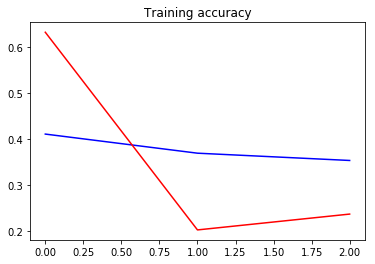

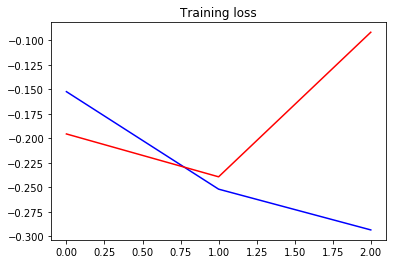

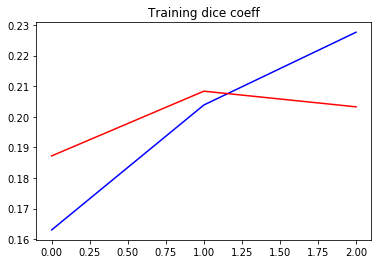

<Figure size 432x288 with 0 Axes>

In [20]:
# loss: -1.0319 - dice_coeff: 0.5650 - acc: 0.9551
# val_loss: -0.9757 - val_dice_coeff: 0.5386 - val_acc: 0.9611

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)

In [22]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V1(df_train.iloc[:idx], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=1, unsharp_amount=1,
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V1(df_train.iloc[idx:], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=1, unsharp_amount=1,
                                    shuffle=False)

history = model_352x544.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


 132/1578 [=>............................] - ETA: 39:06 - loss: -0.2633 - dice_coeff: 0.2290 - acc: 0.36 - ETA: 31:23 - loss: -0.2264 - dice_coeff: 0.2019 - acc: 0.36 - ETA: 29:11 - loss: -0.2020 - dice_coeff: 0.1938 - acc: 0.35 - ETA: 27:48 - loss: -0.1947 - dice_coeff: 0.1868 - acc: 0.34 - ETA: 26:58 - loss: -0.2162 - dice_coeff: 0.1971 - acc: 0.34 - ETA: 26:26 - loss: -0.2112 - dice_coeff: 0.1914 - acc: 0.35 - ETA: 25:58 - loss: -0.1949 - dice_coeff: 0.1825 - acc: 0.36 - ETA: 25:43 - loss: -0.2096 - dice_coeff: 0.1891 - acc: 0.36 - ETA: 25:33 - loss: -0.2037 - dice_coeff: 0.1863 - acc: 0.36 - ETA: 25:30 - loss: -0.2288 - dice_coeff: 0.1987 - acc: 0.37 - ETA: 25:16 - loss: -0.2354 - dice_coeff: 0.2028 - acc: 0.37 - ETA: 24:53 - loss: -0.2414 - dice_coeff: 0.2056 - acc: 0.37 - ETA: 24:32 - loss: -0.2245 - dice_coeff: 0.1980 - acc: 0.37 - ETA: 24:10 - loss: -0.2251 - dice_coeff: 0.1982 - acc: 0.37 - ETA: 23:57 - loss: -0.2366 - dice_coeff: 0.2036 - acc: 0.37 - ETA: 23:49 - loss: -0.237

 264/1578 [====>.........................] - ETA: 19:32 - loss: -0.3154 - dice_coeff: 0.2402 - acc: 0.34 - ETA: 19:30 - loss: -0.3145 - dice_coeff: 0.2399 - acc: 0.34 - ETA: 19:30 - loss: -0.3158 - dice_coeff: 0.2404 - acc: 0.34 - ETA: 19:29 - loss: -0.3141 - dice_coeff: 0.2396 - acc: 0.34 - ETA: 19:28 - loss: -0.3141 - dice_coeff: 0.2395 - acc: 0.34 - ETA: 19:27 - loss: -0.3166 - dice_coeff: 0.2406 - acc: 0.34 - ETA: 19:29 - loss: -0.3158 - dice_coeff: 0.2404 - acc: 0.34 - ETA: 19:28 - loss: -0.3152 - dice_coeff: 0.2400 - acc: 0.34 - ETA: 19:27 - loss: -0.3158 - dice_coeff: 0.2403 - acc: 0.34 - ETA: 19:26 - loss: -0.3158 - dice_coeff: 0.2401 - acc: 0.34 - ETA: 19:25 - loss: -0.3156 - dice_coeff: 0.2398 - acc: 0.34 - ETA: 19:24 - loss: -0.3146 - dice_coeff: 0.2392 - acc: 0.34 - ETA: 19:23 - loss: -0.3157 - dice_coeff: 0.2397 - acc: 0.34 - ETA: 19:21 - loss: -0.3147 - dice_coeff: 0.2391 - acc: 0.34 - ETA: 19:20 - loss: -0.3144 - dice_coeff: 0.2389 - acc: 0.34 - ETA: 19:19 - loss: -0.314

 396/1578 [======>.......................] - ETA: 17:35 - loss: -0.3198 - dice_coeff: 0.2417 - acc: 0.34 - ETA: 17:34 - loss: -0.3202 - dice_coeff: 0.2420 - acc: 0.34 - ETA: 17:33 - loss: -0.3200 - dice_coeff: 0.2419 - acc: 0.34 - ETA: 17:32 - loss: -0.3201 - dice_coeff: 0.2419 - acc: 0.34 - ETA: 17:31 - loss: -0.3189 - dice_coeff: 0.2414 - acc: 0.34 - ETA: 17:31 - loss: -0.3179 - dice_coeff: 0.2409 - acc: 0.34 - ETA: 17:30 - loss: -0.3190 - dice_coeff: 0.2414 - acc: 0.34 - ETA: 17:29 - loss: -0.3193 - dice_coeff: 0.2415 - acc: 0.34 - ETA: 17:28 - loss: -0.3199 - dice_coeff: 0.2418 - acc: 0.34 - ETA: 17:27 - loss: -0.3199 - dice_coeff: 0.2418 - acc: 0.34 - ETA: 17:26 - loss: -0.3198 - dice_coeff: 0.2418 - acc: 0.34 - ETA: 17:25 - loss: -0.3196 - dice_coeff: 0.2417 - acc: 0.34 - ETA: 17:25 - loss: -0.3192 - dice_coeff: 0.2416 - acc: 0.34 - ETA: 17:24 - loss: -0.3188 - dice_coeff: 0.2414 - acc: 0.34 - ETA: 17:23 - loss: -0.3191 - dice_coeff: 0.2415 - acc: 0.34 - ETA: 17:22 - loss: -0.319

 528/1578 [=========>....................] - ETA: 15:44 - loss: -0.3114 - dice_coeff: 0.2384 - acc: 0.35 - ETA: 15:43 - loss: -0.3111 - dice_coeff: 0.2382 - acc: 0.35 - ETA: 15:42 - loss: -0.3112 - dice_coeff: 0.2383 - acc: 0.35 - ETA: 15:42 - loss: -0.3118 - dice_coeff: 0.2385 - acc: 0.35 - ETA: 15:41 - loss: -0.3115 - dice_coeff: 0.2384 - acc: 0.35 - ETA: 15:40 - loss: -0.3119 - dice_coeff: 0.2386 - acc: 0.35 - ETA: 15:39 - loss: -0.3121 - dice_coeff: 0.2387 - acc: 0.35 - ETA: 15:38 - loss: -0.3123 - dice_coeff: 0.2387 - acc: 0.35 - ETA: 15:37 - loss: -0.3123 - dice_coeff: 0.2388 - acc: 0.35 - ETA: 15:37 - loss: -0.3121 - dice_coeff: 0.2388 - acc: 0.35 - ETA: 15:36 - loss: -0.3125 - dice_coeff: 0.2390 - acc: 0.35 - ETA: 15:35 - loss: -0.3122 - dice_coeff: 0.2389 - acc: 0.35 - ETA: 15:34 - loss: -0.3123 - dice_coeff: 0.2389 - acc: 0.35 - ETA: 15:33 - loss: -0.3120 - dice_coeff: 0.2388 - acc: 0.35 - ETA: 15:32 - loss: -0.3120 - dice_coeff: 0.2387 - acc: 0.35 - ETA: 15:32 - loss: -0.312

 660/1578 [===========>..................] - ETA: 13:58 - loss: -0.3197 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 13:57 - loss: -0.3197 - dice_coeff: 0.2425 - acc: 0.35 - ETA: 13:56 - loss: -0.3195 - dice_coeff: 0.2425 - acc: 0.35 - ETA: 13:56 - loss: -0.3191 - dice_coeff: 0.2423 - acc: 0.35 - ETA: 13:55 - loss: -0.3190 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 13:54 - loss: -0.3190 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 13:53 - loss: -0.3193 - dice_coeff: 0.2424 - acc: 0.35 - ETA: 13:52 - loss: -0.3192 - dice_coeff: 0.2423 - acc: 0.35 - ETA: 13:52 - loss: -0.3193 - dice_coeff: 0.2424 - acc: 0.35 - ETA: 13:51 - loss: -0.3196 - dice_coeff: 0.2425 - acc: 0.35 - ETA: 13:50 - loss: -0.3199 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 13:49 - loss: -0.3199 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 13:49 - loss: -0.3200 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 13:48 - loss: -0.3199 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 13:47 - loss: -0.3203 - dice_coeff: 0.2429 - acc: 0.35 - ETA: 13:46 - loss: -0.320

 792/1578 [==============>...............] - ETA: 12:12 - loss: -0.3195 - dice_coeff: 0.2423 - acc: 0.35 - ETA: 12:11 - loss: -0.3191 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 12:10 - loss: -0.3192 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 12:09 - loss: -0.3189 - dice_coeff: 0.2420 - acc: 0.35 - ETA: 12:08 - loss: -0.3192 - dice_coeff: 0.2421 - acc: 0.35 - ETA: 12:08 - loss: -0.3192 - dice_coeff: 0.2421 - acc: 0.35 - ETA: 12:07 - loss: -0.3195 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 12:06 - loss: -0.3195 - dice_coeff: 0.2422 - acc: 0.35 - ETA: 12:05 - loss: -0.3191 - dice_coeff: 0.2420 - acc: 0.35 - ETA: 12:04 - loss: -0.3189 - dice_coeff: 0.2419 - acc: 0.35 - ETA: 12:04 - loss: -0.3186 - dice_coeff: 0.2418 - acc: 0.35 - ETA: 12:03 - loss: -0.3190 - dice_coeff: 0.2420 - acc: 0.35 - ETA: 12:02 - loss: -0.3189 - dice_coeff: 0.2420 - acc: 0.35 - ETA: 12:01 - loss: -0.3192 - dice_coeff: 0.2421 - acc: 0.35 - ETA: 12:00 - loss: -0.3192 - dice_coeff: 0.2421 - acc: 0.35 - ETA: 12:00 - loss: -0.319

 924/1578 [================>.............] - ETA: 10:26 - loss: -0.3206 - dice_coeff: 0.2424 - acc: 0.35 - ETA: 10:25 - loss: -0.3203 - dice_coeff: 0.2423 - acc: 0.35 - ETA: 10:24 - loss: -0.3205 - dice_coeff: 0.2423 - acc: 0.35 - ETA: 10:24 - loss: -0.3205 - dice_coeff: 0.2424 - acc: 0.35 - ETA: 10:23 - loss: -0.3206 - dice_coeff: 0.2424 - acc: 0.35 - ETA: 10:22 - loss: -0.3208 - dice_coeff: 0.2425 - acc: 0.35 - ETA: 10:21 - loss: -0.3211 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 10:20 - loss: -0.3211 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 10:19 - loss: -0.3212 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 10:19 - loss: -0.3213 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 10:18 - loss: -0.3213 - dice_coeff: 0.2428 - acc: 0.35 - ETA: 10:17 - loss: -0.3211 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 10:16 - loss: -0.3210 - dice_coeff: 0.2427 - acc: 0.35 - ETA: 10:15 - loss: -0.3210 - dice_coeff: 0.2426 - acc: 0.35 - ETA: 10:15 - loss: -0.3207 - dice_coeff: 0.2425 - acc: 0.35 - ETA: 10:14 - loss: -0.320

1056/1578 [===================>..........] - ETA: 8:40 - loss: -0.3221 - dice_coeff: 0.2431 - acc: 0.354 - ETA: 8:39 - loss: -0.3221 - dice_coeff: 0.2430 - acc: 0.354 - ETA: 8:38 - loss: -0.3223 - dice_coeff: 0.2431 - acc: 0.354 - ETA: 8:38 - loss: -0.3225 - dice_coeff: 0.2432 - acc: 0.354 - ETA: 8:37 - loss: -0.3221 - dice_coeff: 0.2431 - acc: 0.354 - ETA: 8:36 - loss: -0.3219 - dice_coeff: 0.2430 - acc: 0.353 - ETA: 8:35 - loss: -0.3218 - dice_coeff: 0.2430 - acc: 0.353 - ETA: 8:34 - loss: -0.3218 - dice_coeff: 0.2429 - acc: 0.353 - ETA: 8:34 - loss: -0.3217 - dice_coeff: 0.2429 - acc: 0.353 - ETA: 8:33 - loss: -0.3215 - dice_coeff: 0.2428 - acc: 0.353 - ETA: 8:32 - loss: -0.3214 - dice_coeff: 0.2428 - acc: 0.353 - ETA: 8:31 - loss: -0.3211 - dice_coeff: 0.2427 - acc: 0.353 - ETA: 8:30 - loss: -0.3211 - dice_coeff: 0.2427 - acc: 0.353 - ETA: 8:30 - loss: -0.3211 - dice_coeff: 0.2426 - acc: 0.353 - ETA: 8:29 - loss: -0.3210 - dice_coeff: 0.2426 - acc: 0.353 - ETA: 8:28 - loss: -0.3211

1188/1578 [=====================>........] - ETA: 6:55 - loss: -0.3228 - dice_coeff: 0.2431 - acc: 0.351 - ETA: 6:54 - loss: -0.3226 - dice_coeff: 0.2430 - acc: 0.351 - ETA: 6:53 - loss: -0.3224 - dice_coeff: 0.2429 - acc: 0.351 - ETA: 6:52 - loss: -0.3226 - dice_coeff: 0.2430 - acc: 0.351 - ETA: 6:51 - loss: -0.3225 - dice_coeff: 0.2429 - acc: 0.351 - ETA: 6:51 - loss: -0.3223 - dice_coeff: 0.2429 - acc: 0.351 - ETA: 6:50 - loss: -0.3222 - dice_coeff: 0.2428 - acc: 0.351 - ETA: 6:49 - loss: -0.3219 - dice_coeff: 0.2427 - acc: 0.351 - ETA: 6:48 - loss: -0.3220 - dice_coeff: 0.2427 - acc: 0.351 - ETA: 6:47 - loss: -0.3220 - dice_coeff: 0.2427 - acc: 0.351 - ETA: 6:47 - loss: -0.3219 - dice_coeff: 0.2427 - acc: 0.351 - ETA: 6:46 - loss: -0.3222 - dice_coeff: 0.2428 - acc: 0.351 - ETA: 6:45 - loss: -0.3221 - dice_coeff: 0.2427 - acc: 0.351 - ETA: 6:44 - loss: -0.3222 - dice_coeff: 0.2428 - acc: 0.351 - ETA: 6:44 - loss: -0.3222 - dice_coeff: 0.2428 - acc: 0.351 - ETA: 6:43 - loss: -0.3223

1320/1578 [========================>.....] - ETA: 5:09 - loss: -0.3265 - dice_coeff: 0.2446 - acc: 0.350 - ETA: 5:09 - loss: -0.3263 - dice_coeff: 0.2445 - acc: 0.350 - ETA: 5:08 - loss: -0.3263 - dice_coeff: 0.2445 - acc: 0.350 - ETA: 5:07 - loss: -0.3264 - dice_coeff: 0.2446 - acc: 0.350 - ETA: 5:06 - loss: -0.3264 - dice_coeff: 0.2446 - acc: 0.350 - ETA: 5:05 - loss: -0.3268 - dice_coeff: 0.2448 - acc: 0.350 - ETA: 5:05 - loss: -0.3267 - dice_coeff: 0.2447 - acc: 0.350 - ETA: 5:04 - loss: -0.3268 - dice_coeff: 0.2448 - acc: 0.350 - ETA: 5:03 - loss: -0.3269 - dice_coeff: 0.2448 - acc: 0.350 - ETA: 5:02 - loss: -0.3268 - dice_coeff: 0.2448 - acc: 0.350 - ETA: 5:01 - loss: -0.3265 - dice_coeff: 0.2447 - acc: 0.350 - ETA: 5:01 - loss: -0.3267 - dice_coeff: 0.2447 - acc: 0.350 - ETA: 5:00 - loss: -0.3267 - dice_coeff: 0.2447 - acc: 0.350 - ETA: 4:59 - loss: -0.3266 - dice_coeff: 0.2447 - acc: 0.350 - ETA: 4:58 - loss: -0.3265 - dice_coeff: 0.2446 - acc: 0.350 - ETA: 4:57 - loss: -0.3267

1452/1578 [==========================>...] - ETA: 3:24 - loss: -0.3279 - dice_coeff: 0.2457 - acc: 0.349 - ETA: 3:23 - loss: -0.3279 - dice_coeff: 0.2457 - acc: 0.349 - ETA: 3:23 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:22 - loss: -0.3280 - dice_coeff: 0.2457 - acc: 0.349 - ETA: 3:21 - loss: -0.3279 - dice_coeff: 0.2457 - acc: 0.349 - ETA: 3:20 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:19 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:19 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:18 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:17 - loss: -0.3279 - dice_coeff: 0.2457 - acc: 0.349 - ETA: 3:16 - loss: -0.3278 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:15 - loss: -0.3279 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:15 - loss: -0.3277 - dice_coeff: 0.2456 - acc: 0.349 - ETA: 3:14 - loss: -0.3276 - dice_coeff: 0.2455 - acc: 0.349 - ETA: 3:13 - loss: -0.3275 - dice_coeff: 0.2455 - acc: 0.349 - ETA: 3:12 - loss: -0.3276

1578/1578 [==============================] - ETA: 1:39 - loss: -0.3299 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:38 - loss: -0.3299 - dice_coeff: 0.2466 - acc: 0.347 - ETA: 1:37 - loss: -0.3298 - dice_coeff: 0.2466 - acc: 0.347 - ETA: 1:37 - loss: -0.3298 - dice_coeff: 0.2466 - acc: 0.347 - ETA: 1:36 - loss: -0.3298 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:35 - loss: -0.3296 - dice_coeff: 0.2465 - acc: 0.347 - ETA: 1:34 - loss: -0.3295 - dice_coeff: 0.2465 - acc: 0.347 - ETA: 1:33 - loss: -0.3295 - dice_coeff: 0.2465 - acc: 0.347 - ETA: 1:33 - loss: -0.3297 - dice_coeff: 0.2466 - acc: 0.347 - ETA: 1:32 - loss: -0.3299 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:31 - loss: -0.3299 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:30 - loss: -0.3299 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:29 - loss: -0.3300 - dice_coeff: 0.2468 - acc: 0.347 - ETA: 1:29 - loss: -0.3299 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:28 - loss: -0.3298 - dice_coeff: 0.2467 - acc: 0.347 - ETA: 1:27 - loss: -0.3296

 132/1578 [=>............................] - ETA: 17:06 - loss: -0.2584 - dice_coeff: 0.2222 - acc: 0.28 - ETA: 17:02 - loss: -0.2323 - dice_coeff: 0.2119 - acc: 0.26 - ETA: 17:06 - loss: -0.2509 - dice_coeff: 0.2201 - acc: 0.28 - ETA: 17:07 - loss: -0.3203 - dice_coeff: 0.2495 - acc: 0.30 - ETA: 17:09 - loss: -0.3564 - dice_coeff: 0.2636 - acc: 0.31 - ETA: 17:07 - loss: -0.4427 - dice_coeff: 0.3014 - acc: 0.33 - ETA: 17:09 - loss: -0.4529 - dice_coeff: 0.3066 - acc: 0.33 - ETA: 17:08 - loss: -0.4501 - dice_coeff: 0.3042 - acc: 0.34 - ETA: 17:07 - loss: -0.4419 - dice_coeff: 0.2994 - acc: 0.33 - ETA: 17:08 - loss: -0.4560 - dice_coeff: 0.3065 - acc: 0.33 - ETA: 17:11 - loss: -0.4316 - dice_coeff: 0.2978 - acc: 0.33 - ETA: 17:10 - loss: -0.4170 - dice_coeff: 0.2909 - acc: 0.33 - ETA: 17:09 - loss: -0.4120 - dice_coeff: 0.2875 - acc: 0.33 - ETA: 17:08 - loss: -0.4160 - dice_coeff: 0.2879 - acc: 0.33 - ETA: 17:07 - loss: -0.4066 - dice_coeff: 0.2828 - acc: 0.33 - ETA: 17:07 - loss: -0.400

 264/1578 [====>.........................] - ETA: 17:41 - loss: -0.3430 - dice_coeff: 0.2542 - acc: 0.34 - ETA: 17:41 - loss: -0.3401 - dice_coeff: 0.2529 - acc: 0.33 - ETA: 17:40 - loss: -0.3398 - dice_coeff: 0.2527 - acc: 0.33 - ETA: 17:40 - loss: -0.3387 - dice_coeff: 0.2524 - acc: 0.33 - ETA: 17:40 - loss: -0.3386 - dice_coeff: 0.2523 - acc: 0.33 - ETA: 17:39 - loss: -0.3388 - dice_coeff: 0.2522 - acc: 0.33 - ETA: 17:39 - loss: -0.3368 - dice_coeff: 0.2513 - acc: 0.33 - ETA: 17:39 - loss: -0.3374 - dice_coeff: 0.2515 - acc: 0.33 - ETA: 17:39 - loss: -0.3374 - dice_coeff: 0.2516 - acc: 0.33 - ETA: 17:38 - loss: -0.3392 - dice_coeff: 0.2524 - acc: 0.33 - ETA: 17:38 - loss: -0.3375 - dice_coeff: 0.2517 - acc: 0.33 - ETA: 17:37 - loss: -0.3349 - dice_coeff: 0.2507 - acc: 0.33 - ETA: 17:37 - loss: -0.3342 - dice_coeff: 0.2506 - acc: 0.33 - ETA: 17:37 - loss: -0.3366 - dice_coeff: 0.2519 - acc: 0.33 - ETA: 17:36 - loss: -0.3365 - dice_coeff: 0.2518 - acc: 0.33 - ETA: 17:36 - loss: -0.336

 396/1578 [======>.......................] - ETA: 16:32 - loss: -0.3330 - dice_coeff: 0.2493 - acc: 0.34 - ETA: 16:31 - loss: -0.3340 - dice_coeff: 0.2497 - acc: 0.34 - ETA: 16:30 - loss: -0.3346 - dice_coeff: 0.2501 - acc: 0.34 - ETA: 16:30 - loss: -0.3341 - dice_coeff: 0.2498 - acc: 0.34 - ETA: 16:29 - loss: -0.3344 - dice_coeff: 0.2499 - acc: 0.34 - ETA: 16:28 - loss: -0.3341 - dice_coeff: 0.2497 - acc: 0.34 - ETA: 16:28 - loss: -0.3337 - dice_coeff: 0.2495 - acc: 0.34 - ETA: 16:27 - loss: -0.3339 - dice_coeff: 0.2497 - acc: 0.34 - ETA: 16:26 - loss: -0.3345 - dice_coeff: 0.2499 - acc: 0.34 - ETA: 16:26 - loss: -0.3345 - dice_coeff: 0.2500 - acc: 0.34 - ETA: 16:26 - loss: -0.3353 - dice_coeff: 0.2504 - acc: 0.34 - ETA: 16:26 - loss: -0.3353 - dice_coeff: 0.2504 - acc: 0.34 - ETA: 16:25 - loss: -0.3348 - dice_coeff: 0.2502 - acc: 0.34 - ETA: 16:24 - loss: -0.3347 - dice_coeff: 0.2502 - acc: 0.34 - ETA: 16:24 - loss: -0.3348 - dice_coeff: 0.2502 - acc: 0.34 - ETA: 16:23 - loss: -0.334

 528/1578 [=========>....................] - ETA: 15:01 - loss: -0.3482 - dice_coeff: 0.2566 - acc: 0.34 - ETA: 15:01 - loss: -0.3478 - dice_coeff: 0.2564 - acc: 0.34 - ETA: 15:00 - loss: -0.3478 - dice_coeff: 0.2564 - acc: 0.34 - ETA: 14:59 - loss: -0.3472 - dice_coeff: 0.2562 - acc: 0.34 - ETA: 14:58 - loss: -0.3479 - dice_coeff: 0.2564 - acc: 0.34 - ETA: 14:58 - loss: -0.3478 - dice_coeff: 0.2564 - acc: 0.34 - ETA: 14:57 - loss: -0.3478 - dice_coeff: 0.2564 - acc: 0.34 - ETA: 14:56 - loss: -0.3477 - dice_coeff: 0.2563 - acc: 0.34 - ETA: 14:55 - loss: -0.3473 - dice_coeff: 0.2561 - acc: 0.34 - ETA: 14:55 - loss: -0.3472 - dice_coeff: 0.2560 - acc: 0.34 - ETA: 14:54 - loss: -0.3474 - dice_coeff: 0.2561 - acc: 0.34 - ETA: 14:53 - loss: -0.3472 - dice_coeff: 0.2559 - acc: 0.34 - ETA: 14:52 - loss: -0.3470 - dice_coeff: 0.2559 - acc: 0.34 - ETA: 14:52 - loss: -0.3469 - dice_coeff: 0.2558 - acc: 0.34 - ETA: 14:51 - loss: -0.3470 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 14:50 - loss: -0.346

 660/1578 [===========>..................] - ETA: 13:24 - loss: -0.3476 - dice_coeff: 0.2559 - acc: 0.33 - ETA: 13:23 - loss: -0.3472 - dice_coeff: 0.2557 - acc: 0.33 - ETA: 13:23 - loss: -0.3467 - dice_coeff: 0.2554 - acc: 0.33 - ETA: 13:22 - loss: -0.3475 - dice_coeff: 0.2557 - acc: 0.33 - ETA: 13:21 - loss: -0.3477 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 13:20 - loss: -0.3483 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:20 - loss: -0.3480 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:19 - loss: -0.3481 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:18 - loss: -0.3481 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:17 - loss: -0.3480 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 13:17 - loss: -0.3482 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:16 - loss: -0.3481 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 13:15 - loss: -0.3474 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 13:15 - loss: -0.3475 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 13:14 - loss: -0.3478 - dice_coeff: 0.2559 - acc: 0.33 - ETA: 13:13 - loss: -0.348

 792/1578 [==============>...............] - ETA: 11:46 - loss: -0.3483 - dice_coeff: 0.2561 - acc: 0.33 - ETA: 11:45 - loss: -0.3480 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:44 - loss: -0.3478 - dice_coeff: 0.2559 - acc: 0.33 - ETA: 11:43 - loss: -0.3476 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 11:43 - loss: -0.3477 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 11:42 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:41 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:40 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:40 - loss: -0.3476 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 11:39 - loss: -0.3477 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 11:38 - loss: -0.3478 - dice_coeff: 0.2558 - acc: 0.33 - ETA: 11:37 - loss: -0.3479 - dice_coeff: 0.2559 - acc: 0.33 - ETA: 11:36 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:36 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:35 - loss: -0.3481 - dice_coeff: 0.2560 - acc: 0.33 - ETA: 11:34 - loss: -0.347

 924/1578 [================>.............] - ETA: 10:05 - loss: -0.3527 - dice_coeff: 0.2584 - acc: 0.33 - ETA: 10:05 - loss: -0.3527 - dice_coeff: 0.2584 - acc: 0.33 - ETA: 10:04 - loss: -0.3527 - dice_coeff: 0.2584 - acc: 0.33 - ETA: 10:03 - loss: -0.3524 - dice_coeff: 0.2582 - acc: 0.33 - ETA: 10:02 - loss: -0.3523 - dice_coeff: 0.2582 - acc: 0.33 - ETA: 10:02 - loss: -0.3522 - dice_coeff: 0.2581 - acc: 0.33 - ETA: 10:01 - loss: -0.3521 - dice_coeff: 0.2580 - acc: 0.33 - ETA: 10:00 - loss: -0.3522 - dice_coeff: 0.2581 - acc: 0.33 - ETA: 9:59 - loss: -0.3523 - dice_coeff: 0.2581 - acc: 0.3375 - ETA: 9:58 - loss: -0.3521 - dice_coeff: 0.2580 - acc: 0.337 - ETA: 9:58 - loss: -0.3521 - dice_coeff: 0.2580 - acc: 0.337 - ETA: 9:57 - loss: -0.3519 - dice_coeff: 0.2579 - acc: 0.337 - ETA: 9:56 - loss: -0.3517 - dice_coeff: 0.2578 - acc: 0.337 - ETA: 9:55 - loss: -0.3518 - dice_coeff: 0.2578 - acc: 0.337 - ETA: 9:55 - loss: -0.3515 - dice_coeff: 0.2577 - acc: 0.337 - ETA: 9:54 - loss: -0.351

1056/1578 [===================>..........] - ETA: 8:24 - loss: -0.3533 - dice_coeff: 0.2590 - acc: 0.337 - ETA: 8:24 - loss: -0.3531 - dice_coeff: 0.2589 - acc: 0.337 - ETA: 8:23 - loss: -0.3529 - dice_coeff: 0.2588 - acc: 0.337 - ETA: 8:22 - loss: -0.3530 - dice_coeff: 0.2589 - acc: 0.337 - ETA: 8:22 - loss: -0.3533 - dice_coeff: 0.2590 - acc: 0.338 - ETA: 8:21 - loss: -0.3532 - dice_coeff: 0.2589 - acc: 0.337 - ETA: 8:20 - loss: -0.3535 - dice_coeff: 0.2591 - acc: 0.338 - ETA: 8:19 - loss: -0.3535 - dice_coeff: 0.2591 - acc: 0.338 - ETA: 8:19 - loss: -0.3534 - dice_coeff: 0.2591 - acc: 0.338 - ETA: 8:18 - loss: -0.3535 - dice_coeff: 0.2591 - acc: 0.338 - ETA: 8:17 - loss: -0.3537 - dice_coeff: 0.2592 - acc: 0.338 - ETA: 8:16 - loss: -0.3539 - dice_coeff: 0.2593 - acc: 0.338 - ETA: 8:15 - loss: -0.3538 - dice_coeff: 0.2593 - acc: 0.338 - ETA: 8:15 - loss: -0.3537 - dice_coeff: 0.2592 - acc: 0.338 - ETA: 8:14 - loss: -0.3538 - dice_coeff: 0.2593 - acc: 0.338 - ETA: 8:13 - loss: -0.3538

1188/1578 [=====================>........] - ETA: 6:43 - loss: -0.3544 - dice_coeff: 0.2597 - acc: 0.338 - ETA: 6:42 - loss: -0.3544 - dice_coeff: 0.2597 - acc: 0.338 - ETA: 6:42 - loss: -0.3543 - dice_coeff: 0.2597 - acc: 0.338 - ETA: 6:41 - loss: -0.3541 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:40 - loss: -0.3540 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:39 - loss: -0.3538 - dice_coeff: 0.2595 - acc: 0.337 - ETA: 6:38 - loss: -0.3540 - dice_coeff: 0.2595 - acc: 0.338 - ETA: 6:38 - loss: -0.3539 - dice_coeff: 0.2595 - acc: 0.338 - ETA: 6:37 - loss: -0.3541 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:36 - loss: -0.3540 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:35 - loss: -0.3539 - dice_coeff: 0.2595 - acc: 0.338 - ETA: 6:35 - loss: -0.3539 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:34 - loss: -0.3539 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:33 - loss: -0.3540 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:32 - loss: -0.3541 - dice_coeff: 0.2596 - acc: 0.338 - ETA: 6:31 - loss: -0.3539

1320/1578 [========================>.....] - ETA: 5:01 - loss: -0.3507 - dice_coeff: 0.2579 - acc: 0.337 - ETA: 5:00 - loss: -0.3506 - dice_coeff: 0.2579 - acc: 0.337 - ETA: 5:00 - loss: -0.3507 - dice_coeff: 0.2580 - acc: 0.337 - ETA: 4:59 - loss: -0.3507 - dice_coeff: 0.2580 - acc: 0.337 - ETA: 4:58 - loss: -0.3511 - dice_coeff: 0.2582 - acc: 0.337 - ETA: 4:57 - loss: -0.3512 - dice_coeff: 0.2582 - acc: 0.337 - ETA: 4:56 - loss: -0.3510 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:56 - loss: -0.3510 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:55 - loss: -0.3512 - dice_coeff: 0.2582 - acc: 0.337 - ETA: 4:54 - loss: -0.3511 - dice_coeff: 0.2582 - acc: 0.337 - ETA: 4:53 - loss: -0.3508 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:53 - loss: -0.3508 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:52 - loss: -0.3510 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:51 - loss: -0.3509 - dice_coeff: 0.2581 - acc: 0.337 - ETA: 4:50 - loss: -0.3512 - dice_coeff: 0.2582 - acc: 0.337 - ETA: 4:50 - loss: -0.3514

1452/1578 [==========================>...] - ETA: 3:19 - loss: -0.3478 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 3:18 - loss: -0.3477 - dice_coeff: 0.2565 - acc: 0.336 - ETA: 3:17 - loss: -0.3478 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 3:17 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 3:16 - loss: -0.3480 - dice_coeff: 0.2567 - acc: 0.336 - ETA: 3:15 - loss: -0.3481 - dice_coeff: 0.2567 - acc: 0.336 - ETA: 3:14 - loss: -0.3482 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:14 - loss: -0.3481 - dice_coeff: 0.2567 - acc: 0.336 - ETA: 3:13 - loss: -0.3481 - dice_coeff: 0.2567 - acc: 0.336 - ETA: 3:12 - loss: -0.3482 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:11 - loss: -0.3484 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:10 - loss: -0.3484 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:10 - loss: -0.3484 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:09 - loss: -0.3484 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:08 - loss: -0.3484 - dice_coeff: 0.2568 - acc: 0.336 - ETA: 3:07 - loss: -0.3483

1578/1578 [==============================] - ETA: 1:37 - loss: -0.3478 - dice_coeff: 0.2565 - acc: 0.336 - ETA: 1:36 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:35 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:34 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:33 - loss: -0.3478 - dice_coeff: 0.2565 - acc: 0.336 - ETA: 1:33 - loss: -0.3480 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:32 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:31 - loss: -0.3480 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:30 - loss: -0.3480 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:30 - loss: -0.3480 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:29 - loss: -0.3480 - dice_coeff: 0.2567 - acc: 0.336 - ETA: 1:28 - loss: -0.3478 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:27 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:26 - loss: -0.3479 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:26 - loss: -0.3480 - dice_coeff: 0.2566 - acc: 0.336 - ETA: 1:25 - loss: -0.3481

 132/1578 [=>............................] - ETA: 16:54 - loss: -0.2409 - dice_coeff: 0.1937 - acc: 0.28 - ETA: 16:52 - loss: -0.2834 - dice_coeff: 0.2273 - acc: 0.32 - ETA: 17:06 - loss: -0.2871 - dice_coeff: 0.2273 - acc: 0.30 - ETA: 17:07 - loss: -0.2649 - dice_coeff: 0.2220 - acc: 0.32 - ETA: 17:03 - loss: -0.2888 - dice_coeff: 0.2388 - acc: 0.31 - ETA: 17:06 - loss: -0.2865 - dice_coeff: 0.2367 - acc: 0.31 - ETA: 17:04 - loss: -0.2566 - dice_coeff: 0.2244 - acc: 0.30 - ETA: 17:03 - loss: -0.2907 - dice_coeff: 0.2388 - acc: 0.31 - ETA: 17:02 - loss: -0.2849 - dice_coeff: 0.2344 - acc: 0.30 - ETA: 17:01 - loss: -0.2995 - dice_coeff: 0.2414 - acc: 0.31 - ETA: 17:01 - loss: -0.2937 - dice_coeff: 0.2405 - acc: 0.31 - ETA: 17:03 - loss: -0.2971 - dice_coeff: 0.2422 - acc: 0.32 - ETA: 17:03 - loss: -0.3166 - dice_coeff: 0.2502 - acc: 0.32 - ETA: 17:02 - loss: -0.3160 - dice_coeff: 0.2488 - acc: 0.32 - ETA: 17:02 - loss: -0.3113 - dice_coeff: 0.2462 - acc: 0.32 - ETA: 17:07 - loss: -0.320

 264/1578 [====>.........................] - ETA: 17:40 - loss: -0.3415 - dice_coeff: 0.2548 - acc: 0.34 - ETA: 17:40 - loss: -0.3422 - dice_coeff: 0.2551 - acc: 0.34 - ETA: 17:39 - loss: -0.3406 - dice_coeff: 0.2543 - acc: 0.34 - ETA: 17:39 - loss: -0.3403 - dice_coeff: 0.2542 - acc: 0.34 - ETA: 17:39 - loss: -0.3400 - dice_coeff: 0.2541 - acc: 0.34 - ETA: 17:38 - loss: -0.3395 - dice_coeff: 0.2537 - acc: 0.34 - ETA: 17:38 - loss: -0.3386 - dice_coeff: 0.2534 - acc: 0.34 - ETA: 17:38 - loss: -0.3385 - dice_coeff: 0.2533 - acc: 0.34 - ETA: 17:37 - loss: -0.3374 - dice_coeff: 0.2528 - acc: 0.34 - ETA: 17:37 - loss: -0.3380 - dice_coeff: 0.2530 - acc: 0.34 - ETA: 17:37 - loss: -0.3380 - dice_coeff: 0.2531 - acc: 0.34 - ETA: 17:37 - loss: -0.3395 - dice_coeff: 0.2537 - acc: 0.34 - ETA: 17:37 - loss: -0.3407 - dice_coeff: 0.2543 - acc: 0.34 - ETA: 17:37 - loss: -0.3408 - dice_coeff: 0.2543 - acc: 0.34 - ETA: 17:36 - loss: -0.3416 - dice_coeff: 0.2547 - acc: 0.34 - ETA: 17:36 - loss: -0.340

 396/1578 [======>.......................] - ETA: 16:29 - loss: -0.3452 - dice_coeff: 0.2551 - acc: 0.34 - ETA: 16:28 - loss: -0.3464 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 16:28 - loss: -0.3462 - dice_coeff: 0.2556 - acc: 0.34 - ETA: 16:27 - loss: -0.3458 - dice_coeff: 0.2555 - acc: 0.34 - ETA: 16:28 - loss: -0.3467 - dice_coeff: 0.2559 - acc: 0.34 - ETA: 16:27 - loss: -0.3466 - dice_coeff: 0.2558 - acc: 0.34 - ETA: 16:27 - loss: -0.3466 - dice_coeff: 0.2558 - acc: 0.34 - ETA: 16:26 - loss: -0.3465 - dice_coeff: 0.2558 - acc: 0.34 - ETA: 16:25 - loss: -0.3458 - dice_coeff: 0.2555 - acc: 0.34 - ETA: 16:25 - loss: -0.3458 - dice_coeff: 0.2555 - acc: 0.34 - ETA: 16:24 - loss: -0.3461 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 16:24 - loss: -0.3464 - dice_coeff: 0.2558 - acc: 0.34 - ETA: 16:23 - loss: -0.3456 - dice_coeff: 0.2556 - acc: 0.34 - ETA: 16:22 - loss: -0.3452 - dice_coeff: 0.2554 - acc: 0.34 - ETA: 16:22 - loss: -0.3457 - dice_coeff: 0.2555 - acc: 0.34 - ETA: 16:21 - loss: -0.345

 528/1578 [=========>....................] - ETA: 14:59 - loss: -0.3509 - dice_coeff: 0.2577 - acc: 0.33 - ETA: 14:58 - loss: -0.3506 - dice_coeff: 0.2575 - acc: 0.33 - ETA: 14:57 - loss: -0.3510 - dice_coeff: 0.2577 - acc: 0.33 - ETA: 14:57 - loss: -0.3503 - dice_coeff: 0.2574 - acc: 0.33 - ETA: 14:56 - loss: -0.3503 - dice_coeff: 0.2574 - acc: 0.33 - ETA: 14:55 - loss: -0.3504 - dice_coeff: 0.2574 - acc: 0.33 - ETA: 14:54 - loss: -0.3507 - dice_coeff: 0.2576 - acc: 0.33 - ETA: 14:54 - loss: -0.3515 - dice_coeff: 0.2579 - acc: 0.33 - ETA: 14:53 - loss: -0.3513 - dice_coeff: 0.2578 - acc: 0.33 - ETA: 14:52 - loss: -0.3512 - dice_coeff: 0.2578 - acc: 0.33 - ETA: 14:51 - loss: -0.3508 - dice_coeff: 0.2576 - acc: 0.33 - ETA: 14:51 - loss: -0.3508 - dice_coeff: 0.2576 - acc: 0.33 - ETA: 14:50 - loss: -0.3507 - dice_coeff: 0.2576 - acc: 0.33 - ETA: 14:49 - loss: -0.3510 - dice_coeff: 0.2578 - acc: 0.33 - ETA: 14:48 - loss: -0.3512 - dice_coeff: 0.2579 - acc: 0.33 - ETA: 14:48 - loss: -0.351

 660/1578 [===========>..................] - ETA: 13:22 - loss: -0.3542 - dice_coeff: 0.2593 - acc: 0.33 - ETA: 13:21 - loss: -0.3540 - dice_coeff: 0.2592 - acc: 0.33 - ETA: 13:20 - loss: -0.3544 - dice_coeff: 0.2594 - acc: 0.33 - ETA: 13:20 - loss: -0.3537 - dice_coeff: 0.2591 - acc: 0.33 - ETA: 13:19 - loss: -0.3537 - dice_coeff: 0.2591 - acc: 0.33 - ETA: 13:18 - loss: -0.3537 - dice_coeff: 0.2592 - acc: 0.33 - ETA: 13:17 - loss: -0.3533 - dice_coeff: 0.2590 - acc: 0.33 - ETA: 13:17 - loss: -0.3533 - dice_coeff: 0.2590 - acc: 0.33 - ETA: 13:16 - loss: -0.3536 - dice_coeff: 0.2591 - acc: 0.33 - ETA: 13:15 - loss: -0.3535 - dice_coeff: 0.2591 - acc: 0.33 - ETA: 13:15 - loss: -0.3537 - dice_coeff: 0.2592 - acc: 0.33 - ETA: 13:14 - loss: -0.3535 - dice_coeff: 0.2590 - acc: 0.33 - ETA: 13:13 - loss: -0.3534 - dice_coeff: 0.2590 - acc: 0.33 - ETA: 13:12 - loss: -0.3532 - dice_coeff: 0.2589 - acc: 0.33 - ETA: 13:12 - loss: -0.3537 - dice_coeff: 0.2592 - acc: 0.33 - ETA: 13:11 - loss: -0.353

 792/1578 [==============>...............] - ETA: 11:43 - loss: -0.3543 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:43 - loss: -0.3545 - dice_coeff: 0.2600 - acc: 0.33 - ETA: 11:42 - loss: -0.3547 - dice_coeff: 0.2601 - acc: 0.33 - ETA: 11:41 - loss: -0.3549 - dice_coeff: 0.2601 - acc: 0.33 - ETA: 11:40 - loss: -0.3544 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:40 - loss: -0.3543 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:39 - loss: -0.3542 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:38 - loss: -0.3541 - dice_coeff: 0.2598 - acc: 0.33 - ETA: 11:37 - loss: -0.3541 - dice_coeff: 0.2598 - acc: 0.33 - ETA: 11:37 - loss: -0.3542 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:36 - loss: -0.3543 - dice_coeff: 0.2600 - acc: 0.33 - ETA: 11:35 - loss: -0.3543 - dice_coeff: 0.2600 - acc: 0.33 - ETA: 11:34 - loss: -0.3541 - dice_coeff: 0.2598 - acc: 0.32 - ETA: 11:34 - loss: -0.3542 - dice_coeff: 0.2599 - acc: 0.32 - ETA: 11:33 - loss: -0.3543 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 11:32 - loss: -0.354

 924/1578 [================>.............] - ETA: 10:03 - loss: -0.3539 - dice_coeff: 0.2598 - acc: 0.33 - ETA: 10:03 - loss: -0.3541 - dice_coeff: 0.2599 - acc: 0.33 - ETA: 10:02 - loss: -0.3544 - dice_coeff: 0.2600 - acc: 0.33 - ETA: 10:01 - loss: -0.3548 - dice_coeff: 0.2602 - acc: 0.33 - ETA: 10:00 - loss: -0.3545 - dice_coeff: 0.2601 - acc: 0.33 - ETA: 10:00 - loss: -0.3548 - dice_coeff: 0.2602 - acc: 0.33 - ETA: 9:59 - loss: -0.3548 - dice_coeff: 0.2603 - acc: 0.3322 - ETA: 9:58 - loss: -0.3551 - dice_coeff: 0.2604 - acc: 0.332 - ETA: 9:57 - loss: -0.3552 - dice_coeff: 0.2604 - acc: 0.332 - ETA: 9:57 - loss: -0.3549 - dice_coeff: 0.2603 - acc: 0.332 - ETA: 9:56 - loss: -0.3547 - dice_coeff: 0.2602 - acc: 0.332 - ETA: 9:55 - loss: -0.3547 - dice_coeff: 0.2602 - acc: 0.332 - ETA: 9:54 - loss: -0.3550 - dice_coeff: 0.2603 - acc: 0.332 - ETA: 9:54 - loss: -0.3548 - dice_coeff: 0.2602 - acc: 0.332 - ETA: 9:53 - loss: -0.3553 - dice_coeff: 0.2604 - acc: 0.332 - ETA: 9:52 - loss: -0.355

1056/1578 [===================>..........] - ETA: 8:23 - loss: -0.3545 - dice_coeff: 0.2600 - acc: 0.332 - ETA: 8:22 - loss: -0.3546 - dice_coeff: 0.2600 - acc: 0.332 - ETA: 8:21 - loss: -0.3547 - dice_coeff: 0.2601 - acc: 0.332 - ETA: 8:20 - loss: -0.3547 - dice_coeff: 0.2601 - acc: 0.332 - ETA: 8:20 - loss: -0.3544 - dice_coeff: 0.2599 - acc: 0.332 - ETA: 8:19 - loss: -0.3548 - dice_coeff: 0.2601 - acc: 0.332 - ETA: 8:18 - loss: -0.3552 - dice_coeff: 0.2603 - acc: 0.332 - ETA: 8:17 - loss: -0.3559 - dice_coeff: 0.2606 - acc: 0.332 - ETA: 8:17 - loss: -0.3556 - dice_coeff: 0.2605 - acc: 0.332 - ETA: 8:16 - loss: -0.3558 - dice_coeff: 0.2606 - acc: 0.332 - ETA: 8:15 - loss: -0.3557 - dice_coeff: 0.2605 - acc: 0.332 - ETA: 8:14 - loss: -0.3559 - dice_coeff: 0.2606 - acc: 0.332 - ETA: 8:14 - loss: -0.3559 - dice_coeff: 0.2607 - acc: 0.332 - ETA: 8:13 - loss: -0.3560 - dice_coeff: 0.2607 - acc: 0.332 - ETA: 8:12 - loss: -0.3562 - dice_coeff: 0.2608 - acc: 0.332 - ETA: 8:11 - loss: -0.3563

1188/1578 [=====================>........] - ETA: 6:42 - loss: -0.3592 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:41 - loss: -0.3593 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:40 - loss: -0.3594 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:39 - loss: -0.3597 - dice_coeff: 0.2625 - acc: 0.331 - ETA: 6:38 - loss: -0.3597 - dice_coeff: 0.2626 - acc: 0.331 - ETA: 6:38 - loss: -0.3595 - dice_coeff: 0.2625 - acc: 0.331 - ETA: 6:37 - loss: -0.3594 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:36 - loss: -0.3592 - dice_coeff: 0.2623 - acc: 0.331 - ETA: 6:35 - loss: -0.3591 - dice_coeff: 0.2623 - acc: 0.331 - ETA: 6:35 - loss: -0.3592 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:34 - loss: -0.3591 - dice_coeff: 0.2623 - acc: 0.331 - ETA: 6:33 - loss: -0.3593 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:32 - loss: -0.3591 - dice_coeff: 0.2623 - acc: 0.331 - ETA: 6:32 - loss: -0.3591 - dice_coeff: 0.2623 - acc: 0.331 - ETA: 6:31 - loss: -0.3592 - dice_coeff: 0.2624 - acc: 0.331 - ETA: 6:30 - loss: -0.3592

1320/1578 [========================>.....] - ETA: 5:00 - loss: -0.3626 - dice_coeff: 0.2641 - acc: 0.331 - ETA: 4:59 - loss: -0.3625 - dice_coeff: 0.2640 - acc: 0.331 - ETA: 4:59 - loss: -0.3624 - dice_coeff: 0.2640 - acc: 0.331 - ETA: 4:58 - loss: -0.3624 - dice_coeff: 0.2640 - acc: 0.331 - ETA: 4:57 - loss: -0.3623 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:56 - loss: -0.3624 - dice_coeff: 0.2640 - acc: 0.331 - ETA: 4:55 - loss: -0.3624 - dice_coeff: 0.2640 - acc: 0.331 - ETA: 4:55 - loss: -0.3621 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:54 - loss: -0.3622 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:53 - loss: -0.3623 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:52 - loss: -0.3621 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:52 - loss: -0.3620 - dice_coeff: 0.2639 - acc: 0.331 - ETA: 4:51 - loss: -0.3618 - dice_coeff: 0.2638 - acc: 0.331 - ETA: 4:50 - loss: -0.3618 - dice_coeff: 0.2638 - acc: 0.331 - ETA: 4:49 - loss: -0.3619 - dice_coeff: 0.2638 - acc: 0.331 - ETA: 4:49 - loss: -0.3620

1452/1578 [==========================>...] - ETA: 3:18 - loss: -0.3648 - dice_coeff: 0.2651 - acc: 0.332 - ETA: 3:17 - loss: -0.3649 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:17 - loss: -0.3650 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:16 - loss: -0.3651 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:15 - loss: -0.3650 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:14 - loss: -0.3652 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:14 - loss: -0.3653 - dice_coeff: 0.2653 - acc: 0.332 - ETA: 3:13 - loss: -0.3651 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:12 - loss: -0.3653 - dice_coeff: 0.2653 - acc: 0.332 - ETA: 3:11 - loss: -0.3652 - dice_coeff: 0.2653 - acc: 0.332 - ETA: 3:11 - loss: -0.3649 - dice_coeff: 0.2652 - acc: 0.332 - ETA: 3:10 - loss: -0.3649 - dice_coeff: 0.2651 - acc: 0.332 - ETA: 3:09 - loss: -0.3649 - dice_coeff: 0.2651 - acc: 0.332 - ETA: 3:08 - loss: -0.3647 - dice_coeff: 0.2651 - acc: 0.332 - ETA: 3:07 - loss: -0.3647 - dice_coeff: 0.2651 - acc: 0.332 - ETA: 3:07 - loss: -0.3648

1578/1578 [==============================] - ETA: 1:36 - loss: -0.3611 - dice_coeff: 0.2632 - acc: 0.334 - ETA: 1:35 - loss: -0.3610 - dice_coeff: 0.2631 - acc: 0.334 - ETA: 1:35 - loss: -0.3609 - dice_coeff: 0.2631 - acc: 0.334 - ETA: 1:34 - loss: -0.3607 - dice_coeff: 0.2631 - acc: 0.334 - ETA: 1:33 - loss: -0.3608 - dice_coeff: 0.2631 - acc: 0.334 - ETA: 1:32 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:32 - loss: -0.3606 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:31 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:30 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:29 - loss: -0.3606 - dice_coeff: 0.2629 - acc: 0.334 - ETA: 1:28 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:28 - loss: -0.3608 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:27 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:26 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:25 - loss: -0.3607 - dice_coeff: 0.2630 - acc: 0.334 - ETA: 1:25 - loss: -0.3605

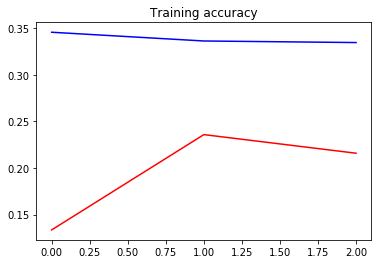

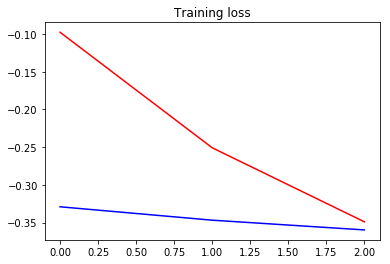

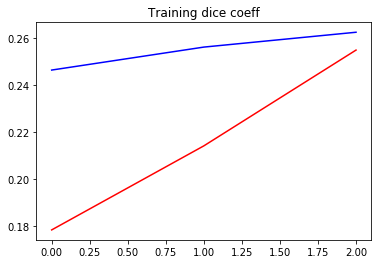

<Figure size 432x288 with 0 Axes>

In [23]:
plot_training(history)

In [26]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V1(df_train.iloc[:idx], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=1, unsharp_amount=1,
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V1(df_train.iloc[idx:], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=1, unsharp_amount=1,
                                    shuffle=False)

history = model_352x544.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


 132/1578 [=>............................] - ETA: 38:38 - loss: -0.7937 - dice_coeff: 0.4641 - acc: 0.30 - ETA: 30:49 - loss: -0.4195 - dice_coeff: 0.3126 - acc: 0.34 - ETA: 28:03 - loss: -0.4939 - dice_coeff: 0.3358 - acc: 0.33 - ETA: 27:04 - loss: -0.3551 - dice_coeff: 0.2747 - acc: 0.32 - ETA: 26:23 - loss: -0.3014 - dice_coeff: 0.2472 - acc: 0.30 - ETA: 25:51 - loss: -0.3202 - dice_coeff: 0.2510 - acc: 0.31 - ETA: 25:20 - loss: -0.3281 - dice_coeff: 0.2518 - acc: 0.31 - ETA: 25:02 - loss: -0.3206 - dice_coeff: 0.2461 - acc: 0.32 - ETA: 24:52 - loss: -0.2858 - dice_coeff: 0.2297 - acc: 0.31 - ETA: 24:41 - loss: -0.3020 - dice_coeff: 0.2374 - acc: 0.32 - ETA: 24:37 - loss: -0.2928 - dice_coeff: 0.2319 - acc: 0.32 - ETA: 24:21 - loss: -0.2934 - dice_coeff: 0.2326 - acc: 0.32 - ETA: 24:02 - loss: -0.3015 - dice_coeff: 0.2359 - acc: 0.33 - ETA: 23:46 - loss: -0.2965 - dice_coeff: 0.2347 - acc: 0.33 - ETA: 23:29 - loss: -0.2958 - dice_coeff: 0.2325 - acc: 0.33 - ETA: 23:17 - loss: -0.307

 264/1578 [====>.........................] - ETA: 18:56 - loss: -0.3480 - dice_coeff: 0.2561 - acc: 0.34 - ETA: 18:55 - loss: -0.3483 - dice_coeff: 0.2562 - acc: 0.34 - ETA: 18:54 - loss: -0.3475 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 18:53 - loss: -0.3474 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 18:52 - loss: -0.3483 - dice_coeff: 0.2560 - acc: 0.34 - ETA: 18:51 - loss: -0.3490 - dice_coeff: 0.2561 - acc: 0.34 - ETA: 18:50 - loss: -0.3484 - dice_coeff: 0.2561 - acc: 0.34 - ETA: 18:49 - loss: -0.3504 - dice_coeff: 0.2570 - acc: 0.34 - ETA: 18:48 - loss: -0.3502 - dice_coeff: 0.2569 - acc: 0.34 - ETA: 18:47 - loss: -0.3502 - dice_coeff: 0.2571 - acc: 0.34 - ETA: 18:47 - loss: -0.3492 - dice_coeff: 0.2566 - acc: 0.34 - ETA: 18:46 - loss: -0.3483 - dice_coeff: 0.2562 - acc: 0.34 - ETA: 18:45 - loss: -0.3500 - dice_coeff: 0.2570 - acc: 0.34 - ETA: 18:44 - loss: -0.3484 - dice_coeff: 0.2562 - acc: 0.34 - ETA: 18:43 - loss: -0.3474 - dice_coeff: 0.2557 - acc: 0.34 - ETA: 18:42 - loss: -0.347

 396/1578 [======>.......................] - ETA: 17:04 - loss: -0.3506 - dice_coeff: 0.2578 - acc: 0.35 - ETA: 17:04 - loss: -0.3501 - dice_coeff: 0.2577 - acc: 0.35 - ETA: 17:03 - loss: -0.3495 - dice_coeff: 0.2574 - acc: 0.35 - ETA: 17:02 - loss: -0.3493 - dice_coeff: 0.2573 - acc: 0.34 - ETA: 17:01 - loss: -0.3491 - dice_coeff: 0.2573 - acc: 0.34 - ETA: 17:00 - loss: -0.3486 - dice_coeff: 0.2571 - acc: 0.34 - ETA: 16:59 - loss: -0.3491 - dice_coeff: 0.2574 - acc: 0.34 - ETA: 16:58 - loss: -0.3494 - dice_coeff: 0.2575 - acc: 0.35 - ETA: 16:58 - loss: -0.3502 - dice_coeff: 0.2577 - acc: 0.34 - ETA: 16:57 - loss: -0.3504 - dice_coeff: 0.2578 - acc: 0.34 - ETA: 16:56 - loss: -0.3502 - dice_coeff: 0.2577 - acc: 0.34 - ETA: 16:55 - loss: -0.3509 - dice_coeff: 0.2581 - acc: 0.35 - ETA: 16:54 - loss: -0.3508 - dice_coeff: 0.2581 - acc: 0.35 - ETA: 16:53 - loss: -0.3523 - dice_coeff: 0.2587 - acc: 0.35 - ETA: 16:52 - loss: -0.3518 - dice_coeff: 0.2585 - acc: 0.35 - ETA: 16:52 - loss: -0.352

 528/1578 [=========>....................] - ETA: 15:18 - loss: -0.3616 - dice_coeff: 0.2636 - acc: 0.34 - ETA: 15:17 - loss: -0.3614 - dice_coeff: 0.2635 - acc: 0.34 - ETA: 15:16 - loss: -0.3614 - dice_coeff: 0.2635 - acc: 0.34 - ETA: 15:15 - loss: -0.3618 - dice_coeff: 0.2636 - acc: 0.35 - ETA: 15:15 - loss: -0.3622 - dice_coeff: 0.2638 - acc: 0.35 - ETA: 15:14 - loss: -0.3627 - dice_coeff: 0.2641 - acc: 0.35 - ETA: 15:13 - loss: -0.3628 - dice_coeff: 0.2641 - acc: 0.35 - ETA: 15:12 - loss: -0.3626 - dice_coeff: 0.2640 - acc: 0.35 - ETA: 15:11 - loss: -0.3622 - dice_coeff: 0.2638 - acc: 0.35 - ETA: 15:11 - loss: -0.3627 - dice_coeff: 0.2641 - acc: 0.35 - ETA: 15:10 - loss: -0.3619 - dice_coeff: 0.2637 - acc: 0.35 - ETA: 15:09 - loss: -0.3618 - dice_coeff: 0.2637 - acc: 0.35 - ETA: 15:08 - loss: -0.3619 - dice_coeff: 0.2637 - acc: 0.35 - ETA: 15:07 - loss: -0.3623 - dice_coeff: 0.2639 - acc: 0.35 - ETA: 15:07 - loss: -0.3619 - dice_coeff: 0.2638 - acc: 0.35 - ETA: 15:06 - loss: -0.361

 660/1578 [===========>..................] - ETA: 13:33 - loss: -0.3594 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 13:33 - loss: -0.3598 - dice_coeff: 0.2625 - acc: 0.34 - ETA: 13:32 - loss: -0.3595 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 13:31 - loss: -0.3604 - dice_coeff: 0.2628 - acc: 0.34 - ETA: 13:30 - loss: -0.3605 - dice_coeff: 0.2629 - acc: 0.34 - ETA: 13:30 - loss: -0.3613 - dice_coeff: 0.2632 - acc: 0.34 - ETA: 13:29 - loss: -0.3608 - dice_coeff: 0.2630 - acc: 0.34 - ETA: 13:28 - loss: -0.3611 - dice_coeff: 0.2631 - acc: 0.34 - ETA: 13:27 - loss: -0.3618 - dice_coeff: 0.2634 - acc: 0.34 - ETA: 13:26 - loss: -0.3620 - dice_coeff: 0.2635 - acc: 0.34 - ETA: 13:26 - loss: -0.3619 - dice_coeff: 0.2634 - acc: 0.34 - ETA: 13:25 - loss: -0.3619 - dice_coeff: 0.2634 - acc: 0.34 - ETA: 13:24 - loss: -0.3618 - dice_coeff: 0.2634 - acc: 0.34 - ETA: 13:23 - loss: -0.3619 - dice_coeff: 0.2635 - acc: 0.34 - ETA: 13:22 - loss: -0.3619 - dice_coeff: 0.2635 - acc: 0.34 - ETA: 13:22 - loss: -0.361

 792/1578 [==============>...............] - ETA: 11:51 - loss: -0.3602 - dice_coeff: 0.2624 - acc: 0.34 - ETA: 11:50 - loss: -0.3599 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:49 - loss: -0.3601 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:48 - loss: -0.3603 - dice_coeff: 0.2625 - acc: 0.34 - ETA: 11:48 - loss: -0.3603 - dice_coeff: 0.2624 - acc: 0.34 - ETA: 11:47 - loss: -0.3602 - dice_coeff: 0.2624 - acc: 0.34 - ETA: 11:46 - loss: -0.3602 - dice_coeff: 0.2624 - acc: 0.34 - ETA: 11:45 - loss: -0.3601 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:45 - loss: -0.3601 - dice_coeff: 0.2624 - acc: 0.34 - ETA: 11:44 - loss: -0.3600 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:43 - loss: -0.3600 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:42 - loss: -0.3600 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:42 - loss: -0.3604 - dice_coeff: 0.2625 - acc: 0.34 - ETA: 11:41 - loss: -0.3600 - dice_coeff: 0.2623 - acc: 0.34 - ETA: 11:40 - loss: -0.3595 - dice_coeff: 0.2621 - acc: 0.34 - ETA: 11:39 - loss: -0.359

 924/1578 [================>.............] - ETA: 10:09 - loss: -0.3667 - dice_coeff: 0.2655 - acc: 0.35 - ETA: 10:08 - loss: -0.3668 - dice_coeff: 0.2655 - acc: 0.35 - ETA: 10:07 - loss: -0.3667 - dice_coeff: 0.2655 - acc: 0.35 - ETA: 10:06 - loss: -0.3666 - dice_coeff: 0.2654 - acc: 0.35 - ETA: 10:06 - loss: -0.3666 - dice_coeff: 0.2654 - acc: 0.35 - ETA: 10:05 - loss: -0.3665 - dice_coeff: 0.2654 - acc: 0.35 - ETA: 10:04 - loss: -0.3663 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 10:03 - loss: -0.3663 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 10:03 - loss: -0.3662 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 10:02 - loss: -0.3663 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 10:01 - loss: -0.3663 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 10:00 - loss: -0.3664 - dice_coeff: 0.2653 - acc: 0.35 - ETA: 9:59 - loss: -0.3663 - dice_coeff: 0.2653 - acc: 0.3525 - ETA: 9:59 - loss: -0.3666 - dice_coeff: 0.2654 - acc: 0.352 - ETA: 9:58 - loss: -0.3670 - dice_coeff: 0.2656 - acc: 0.352 - ETA: 9:57 - loss: -0.367

1056/1578 [===================>..........] - ETA: 8:27 - loss: -0.3738 - dice_coeff: 0.2690 - acc: 0.353 - ETA: 8:26 - loss: -0.3740 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:25 - loss: -0.3742 - dice_coeff: 0.2692 - acc: 0.353 - ETA: 8:24 - loss: -0.3745 - dice_coeff: 0.2693 - acc: 0.354 - ETA: 8:23 - loss: -0.3743 - dice_coeff: 0.2693 - acc: 0.353 - ETA: 8:23 - loss: -0.3741 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:22 - loss: -0.3739 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:21 - loss: -0.3739 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:20 - loss: -0.3740 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:20 - loss: -0.3739 - dice_coeff: 0.2691 - acc: 0.353 - ETA: 8:19 - loss: -0.3742 - dice_coeff: 0.2692 - acc: 0.354 - ETA: 8:18 - loss: -0.3741 - dice_coeff: 0.2692 - acc: 0.354 - ETA: 8:17 - loss: -0.3742 - dice_coeff: 0.2692 - acc: 0.354 - ETA: 8:16 - loss: -0.3741 - dice_coeff: 0.2692 - acc: 0.353 - ETA: 8:16 - loss: -0.3740 - dice_coeff: 0.2691 - acc: 0.354 - ETA: 8:15 - loss: -0.3742

1188/1578 [=====================>........] - ETA: 6:44 - loss: -0.3759 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:43 - loss: -0.3760 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:43 - loss: -0.3761 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:42 - loss: -0.3761 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:41 - loss: -0.3761 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:40 - loss: -0.3762 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:39 - loss: -0.3762 - dice_coeff: 0.2705 - acc: 0.355 - ETA: 6:39 - loss: -0.3762 - dice_coeff: 0.2704 - acc: 0.355 - ETA: 6:38 - loss: -0.3760 - dice_coeff: 0.2703 - acc: 0.355 - ETA: 6:37 - loss: -0.3760 - dice_coeff: 0.2703 - acc: 0.355 - ETA: 6:36 - loss: -0.3759 - dice_coeff: 0.2703 - acc: 0.355 - ETA: 6:36 - loss: -0.3757 - dice_coeff: 0.2702 - acc: 0.355 - ETA: 6:35 - loss: -0.3758 - dice_coeff: 0.2702 - acc: 0.356 - ETA: 6:34 - loss: -0.3756 - dice_coeff: 0.2702 - acc: 0.355 - ETA: 6:33 - loss: -0.3756 - dice_coeff: 0.2701 - acc: 0.355 - ETA: 6:32 - loss: -0.3758

1320/1578 [========================>.....] - ETA: 5:02 - loss: -0.3781 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 5:01 - loss: -0.3779 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 5:00 - loss: -0.3779 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 4:59 - loss: -0.3780 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 4:58 - loss: -0.3779 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 4:58 - loss: -0.3780 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 4:57 - loss: -0.3780 - dice_coeff: 0.2714 - acc: 0.356 - ETA: 4:56 - loss: -0.3781 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 4:55 - loss: -0.3781 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 4:55 - loss: -0.3783 - dice_coeff: 0.2716 - acc: 0.356 - ETA: 4:54 - loss: -0.3783 - dice_coeff: 0.2716 - acc: 0.356 - ETA: 4:53 - loss: -0.3782 - dice_coeff: 0.2716 - acc: 0.356 - ETA: 4:52 - loss: -0.3781 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 4:52 - loss: -0.3780 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 4:51 - loss: -0.3780 - dice_coeff: 0.2715 - acc: 0.356 - ETA: 4:50 - loss: -0.3778

1452/1578 [==========================>...] - ETA: 3:19 - loss: -0.3789 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:18 - loss: -0.3788 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:18 - loss: -0.3786 - dice_coeff: 0.2718 - acc: 0.355 - ETA: 3:17 - loss: -0.3787 - dice_coeff: 0.2718 - acc: 0.355 - ETA: 3:16 - loss: -0.3787 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:15 - loss: -0.3787 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:14 - loss: -0.3789 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:14 - loss: -0.3789 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:13 - loss: -0.3790 - dice_coeff: 0.2720 - acc: 0.355 - ETA: 3:12 - loss: -0.3788 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:11 - loss: -0.3787 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:11 - loss: -0.3787 - dice_coeff: 0.2719 - acc: 0.355 - ETA: 3:10 - loss: -0.3786 - dice_coeff: 0.2718 - acc: 0.355 - ETA: 3:09 - loss: -0.3785 - dice_coeff: 0.2718 - acc: 0.355 - ETA: 3:08 - loss: -0.3786 - dice_coeff: 0.2718 - acc: 0.355 - ETA: 3:07 - loss: -0.3786

1578/1578 [==============================] - ETA: 1:37 - loss: -0.3795 - dice_coeff: 0.2723 - acc: 0.356 - ETA: 1:36 - loss: -0.3793 - dice_coeff: 0.2723 - acc: 0.356 - ETA: 1:35 - loss: -0.3793 - dice_coeff: 0.2722 - acc: 0.356 - ETA: 1:34 - loss: -0.3795 - dice_coeff: 0.2723 - acc: 0.356 - ETA: 1:33 - loss: -0.3796 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:33 - loss: -0.3795 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:32 - loss: -0.3795 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:31 - loss: -0.3795 - dice_coeff: 0.2723 - acc: 0.356 - ETA: 1:30 - loss: -0.3795 - dice_coeff: 0.2723 - acc: 0.356 - ETA: 1:30 - loss: -0.3797 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:29 - loss: -0.3796 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:28 - loss: -0.3797 - dice_coeff: 0.2724 - acc: 0.356 - ETA: 1:27 - loss: -0.3798 - dice_coeff: 0.2725 - acc: 0.356 - ETA: 1:26 - loss: -0.3798 - dice_coeff: 0.2725 - acc: 0.356 - ETA: 1:26 - loss: -0.3798 - dice_coeff: 0.2725 - acc: 0.356 - ETA: 1:25 - loss: -0.3796

 132/1578 [=>............................] - ETA: 17:05 - loss: -0.2498 - dice_coeff: 0.2106 - acc: 0.36 - ETA: 17:05 - loss: -0.2822 - dice_coeff: 0.2287 - acc: 0.30 - ETA: 17:07 - loss: -0.3057 - dice_coeff: 0.2379 - acc: 0.30 - ETA: 17:07 - loss: -0.3385 - dice_coeff: 0.2548 - acc: 0.31 - ETA: 17:06 - loss: -0.3916 - dice_coeff: 0.2815 - acc: 0.32 - ETA: 17:08 - loss: -0.4105 - dice_coeff: 0.2894 - acc: 0.33 - ETA: 17:10 - loss: -0.4225 - dice_coeff: 0.2974 - acc: 0.33 - ETA: 17:12 - loss: -0.4221 - dice_coeff: 0.2967 - acc: 0.33 - ETA: 17:11 - loss: -0.4268 - dice_coeff: 0.2953 - acc: 0.32 - ETA: 17:11 - loss: -0.4781 - dice_coeff: 0.3200 - acc: 0.33 - ETA: 17:10 - loss: -0.4611 - dice_coeff: 0.3130 - acc: 0.33 - ETA: 17:09 - loss: -0.4920 - dice_coeff: 0.3264 - acc: 0.33 - ETA: 17:10 - loss: -0.4782 - dice_coeff: 0.3219 - acc: 0.33 - ETA: 17:10 - loss: -0.4874 - dice_coeff: 0.3254 - acc: 0.33 - ETA: 17:07 - loss: -0.4551 - dice_coeff: 0.3109 - acc: 0.33 - ETA: 17:07 - loss: -0.442

 264/1578 [====>.........................] - ETA: 17:35 - loss: -0.4180 - dice_coeff: 0.2942 - acc: 0.35 - ETA: 17:35 - loss: -0.4186 - dice_coeff: 0.2944 - acc: 0.35 - ETA: 17:34 - loss: -0.4196 - dice_coeff: 0.2946 - acc: 0.35 - ETA: 17:34 - loss: -0.4197 - dice_coeff: 0.2947 - acc: 0.35 - ETA: 17:33 - loss: -0.4186 - dice_coeff: 0.2941 - acc: 0.35 - ETA: 17:33 - loss: -0.4215 - dice_coeff: 0.2955 - acc: 0.35 - ETA: 17:33 - loss: -0.4202 - dice_coeff: 0.2949 - acc: 0.35 - ETA: 17:32 - loss: -0.4191 - dice_coeff: 0.2943 - acc: 0.35 - ETA: 17:32 - loss: -0.4190 - dice_coeff: 0.2943 - acc: 0.35 - ETA: 17:31 - loss: -0.4198 - dice_coeff: 0.2946 - acc: 0.35 - ETA: 17:31 - loss: -0.4213 - dice_coeff: 0.2953 - acc: 0.35 - ETA: 17:30 - loss: -0.4232 - dice_coeff: 0.2961 - acc: 0.35 - ETA: 17:30 - loss: -0.4260 - dice_coeff: 0.2974 - acc: 0.35 - ETA: 17:29 - loss: -0.4273 - dice_coeff: 0.2980 - acc: 0.35 - ETA: 17:29 - loss: -0.4260 - dice_coeff: 0.2974 - acc: 0.35 - ETA: 17:28 - loss: -0.426

 396/1578 [======>.......................] - ETA: 16:26 - loss: -0.3775 - dice_coeff: 0.2732 - acc: 0.35 - ETA: 16:25 - loss: -0.3784 - dice_coeff: 0.2735 - acc: 0.35 - ETA: 16:24 - loss: -0.3799 - dice_coeff: 0.2742 - acc: 0.35 - ETA: 16:24 - loss: -0.3798 - dice_coeff: 0.2741 - acc: 0.35 - ETA: 16:23 - loss: -0.3805 - dice_coeff: 0.2744 - acc: 0.35 - ETA: 16:22 - loss: -0.3803 - dice_coeff: 0.2744 - acc: 0.35 - ETA: 16:22 - loss: -0.3801 - dice_coeff: 0.2743 - acc: 0.35 - ETA: 16:21 - loss: -0.3808 - dice_coeff: 0.2747 - acc: 0.35 - ETA: 16:21 - loss: -0.3800 - dice_coeff: 0.2743 - acc: 0.35 - ETA: 16:20 - loss: -0.3784 - dice_coeff: 0.2736 - acc: 0.35 - ETA: 16:19 - loss: -0.3796 - dice_coeff: 0.2741 - acc: 0.35 - ETA: 16:19 - loss: -0.3790 - dice_coeff: 0.2739 - acc: 0.35 - ETA: 16:18 - loss: -0.3777 - dice_coeff: 0.2734 - acc: 0.35 - ETA: 16:17 - loss: -0.3772 - dice_coeff: 0.2732 - acc: 0.35 - ETA: 16:17 - loss: -0.3761 - dice_coeff: 0.2726 - acc: 0.35 - ETA: 16:16 - loss: -0.376

 528/1578 [=========>....................] - ETA: 14:54 - loss: -0.3716 - dice_coeff: 0.2699 - acc: 0.35 - ETA: 14:54 - loss: -0.3716 - dice_coeff: 0.2699 - acc: 0.35 - ETA: 14:53 - loss: -0.3717 - dice_coeff: 0.2699 - acc: 0.35 - ETA: 14:52 - loss: -0.3723 - dice_coeff: 0.2702 - acc: 0.35 - ETA: 14:51 - loss: -0.3725 - dice_coeff: 0.2703 - acc: 0.35 - ETA: 14:51 - loss: -0.3720 - dice_coeff: 0.2700 - acc: 0.35 - ETA: 14:50 - loss: -0.3721 - dice_coeff: 0.2700 - acc: 0.35 - ETA: 14:49 - loss: -0.3721 - dice_coeff: 0.2700 - acc: 0.35 - ETA: 14:49 - loss: -0.3723 - dice_coeff: 0.2701 - acc: 0.35 - ETA: 14:48 - loss: -0.3728 - dice_coeff: 0.2703 - acc: 0.35 - ETA: 14:47 - loss: -0.3726 - dice_coeff: 0.2703 - acc: 0.35 - ETA: 14:46 - loss: -0.3728 - dice_coeff: 0.2703 - acc: 0.35 - ETA: 14:46 - loss: -0.3738 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 14:45 - loss: -0.3738 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 14:44 - loss: -0.3743 - dice_coeff: 0.2710 - acc: 0.35 - ETA: 14:43 - loss: -0.374

 660/1578 [===========>..................] - ETA: 13:17 - loss: -0.3766 - dice_coeff: 0.2718 - acc: 0.35 - ETA: 13:16 - loss: -0.3760 - dice_coeff: 0.2715 - acc: 0.35 - ETA: 13:16 - loss: -0.3753 - dice_coeff: 0.2713 - acc: 0.35 - ETA: 13:15 - loss: -0.3746 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 13:14 - loss: -0.3747 - dice_coeff: 0.2711 - acc: 0.35 - ETA: 13:13 - loss: -0.3742 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 13:13 - loss: -0.3740 - dice_coeff: 0.2707 - acc: 0.35 - ETA: 13:13 - loss: -0.3740 - dice_coeff: 0.2707 - acc: 0.35 - ETA: 13:12 - loss: -0.3741 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 13:11 - loss: -0.3743 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 13:10 - loss: -0.3744 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 13:10 - loss: -0.3746 - dice_coeff: 0.2710 - acc: 0.35 - ETA: 13:09 - loss: -0.3742 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 13:08 - loss: -0.3740 - dice_coeff: 0.2707 - acc: 0.35 - ETA: 13:07 - loss: -0.3736 - dice_coeff: 0.2706 - acc: 0.35 - ETA: 13:07 - loss: -0.374

 792/1578 [==============>...............] - ETA: 11:40 - loss: -0.3747 - dice_coeff: 0.2712 - acc: 0.35 - ETA: 11:39 - loss: -0.3747 - dice_coeff: 0.2713 - acc: 0.35 - ETA: 11:38 - loss: -0.3745 - dice_coeff: 0.2712 - acc: 0.35 - ETA: 11:37 - loss: -0.3740 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:37 - loss: -0.3740 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:36 - loss: -0.3740 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:35 - loss: -0.3738 - dice_coeff: 0.2708 - acc: 0.35 - ETA: 11:34 - loss: -0.3741 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:34 - loss: -0.3741 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:33 - loss: -0.3740 - dice_coeff: 0.2709 - acc: 0.35 - ETA: 11:32 - loss: -0.3744 - dice_coeff: 0.2711 - acc: 0.35 - ETA: 11:31 - loss: -0.3751 - dice_coeff: 0.2714 - acc: 0.35 - ETA: 11:31 - loss: -0.3750 - dice_coeff: 0.2714 - acc: 0.35 - ETA: 11:30 - loss: -0.3747 - dice_coeff: 0.2712 - acc: 0.35 - ETA: 11:29 - loss: -0.3751 - dice_coeff: 0.2714 - acc: 0.35 - ETA: 11:28 - loss: -0.375

 924/1578 [================>.............] - ETA: 10:00 - loss: -0.3777 - dice_coeff: 0.2725 - acc: 0.35 - ETA: 9:59 - loss: -0.3776 - dice_coeff: 0.2724 - acc: 0.3532 - ETA: 9:58 - loss: -0.3775 - dice_coeff: 0.2724 - acc: 0.353 - ETA: 9:58 - loss: -0.3778 - dice_coeff: 0.2725 - acc: 0.353 - ETA: 9:57 - loss: -0.3776 - dice_coeff: 0.2724 - acc: 0.353 - ETA: 9:56 - loss: -0.3774 - dice_coeff: 0.2723 - acc: 0.353 - ETA: 9:56 - loss: -0.3772 - dice_coeff: 0.2722 - acc: 0.352 - ETA: 9:55 - loss: -0.3774 - dice_coeff: 0.2723 - acc: 0.352 - ETA: 9:54 - loss: -0.3778 - dice_coeff: 0.2724 - acc: 0.352 - ETA: 9:53 - loss: -0.3777 - dice_coeff: 0.2724 - acc: 0.352 - ETA: 9:52 - loss: -0.3774 - dice_coeff: 0.2723 - acc: 0.352 - ETA: 9:52 - loss: -0.3773 - dice_coeff: 0.2723 - acc: 0.352 - ETA: 9:51 - loss: -0.3772 - dice_coeff: 0.2722 - acc: 0.352 - ETA: 9:50 - loss: -0.3772 - dice_coeff: 0.2722 - acc: 0.352 - ETA: 9:49 - loss: -0.3773 - dice_coeff: 0.2723 - acc: 0.352 - ETA: 9:49 - loss: -0.377

1056/1578 [===================>..........] - ETA: 8:20 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:19 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:19 - loss: -0.3780 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:18 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.354 - ETA: 8:17 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.354 - ETA: 8:16 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:15 - loss: -0.3783 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:15 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:14 - loss: -0.3780 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:13 - loss: -0.3779 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:12 - loss: -0.3780 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:12 - loss: -0.3781 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:11 - loss: -0.3781 - dice_coeff: 0.2726 - acc: 0.353 - ETA: 8:10 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:09 - loss: -0.3782 - dice_coeff: 0.2727 - acc: 0.353 - ETA: 8:09 - loss: -0.3783

1188/1578 [=====================>........] - ETA: 6:39 - loss: -0.3776 - dice_coeff: 0.2725 - acc: 0.355 - ETA: 6:38 - loss: -0.3775 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:38 - loss: -0.3776 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:37 - loss: -0.3775 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:36 - loss: -0.3779 - dice_coeff: 0.2726 - acc: 0.355 - ETA: 6:35 - loss: -0.3777 - dice_coeff: 0.2725 - acc: 0.355 - ETA: 6:35 - loss: -0.3777 - dice_coeff: 0.2725 - acc: 0.355 - ETA: 6:34 - loss: -0.3774 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:33 - loss: -0.3774 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:32 - loss: -0.3774 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:32 - loss: -0.3776 - dice_coeff: 0.2724 - acc: 0.355 - ETA: 6:31 - loss: -0.3777 - dice_coeff: 0.2725 - acc: 0.355 - ETA: 6:30 - loss: -0.3779 - dice_coeff: 0.2726 - acc: 0.355 - ETA: 6:29 - loss: -0.3778 - dice_coeff: 0.2726 - acc: 0.355 - ETA: 6:29 - loss: -0.3780 - dice_coeff: 0.2727 - acc: 0.355 - ETA: 6:28 - loss: -0.3782

1320/1578 [========================>.....] - ETA: 4:58 - loss: -0.3799 - dice_coeff: 0.2735 - acc: 0.356 - ETA: 4:58 - loss: -0.3798 - dice_coeff: 0.2735 - acc: 0.356 - ETA: 4:57 - loss: -0.3798 - dice_coeff: 0.2734 - acc: 0.356 - ETA: 4:56 - loss: -0.3797 - dice_coeff: 0.2734 - acc: 0.356 - ETA: 4:55 - loss: -0.3793 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:54 - loss: -0.3793 - dice_coeff: 0.2732 - acc: 0.356 - ETA: 4:54 - loss: -0.3794 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:53 - loss: -0.3795 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:52 - loss: -0.3796 - dice_coeff: 0.2734 - acc: 0.356 - ETA: 4:51 - loss: -0.3795 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:51 - loss: -0.3794 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:50 - loss: -0.3795 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:49 - loss: -0.3794 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:48 - loss: -0.3795 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:48 - loss: -0.3794 - dice_coeff: 0.2733 - acc: 0.356 - ETA: 4:47 - loss: -0.3792

1452/1578 [==========================>...] - ETA: 3:17 - loss: -0.3838 - dice_coeff: 0.2753 - acc: 0.356 - ETA: 3:16 - loss: -0.3837 - dice_coeff: 0.2752 - acc: 0.356 - ETA: 3:16 - loss: -0.3833 - dice_coeff: 0.2750 - acc: 0.356 - ETA: 3:15 - loss: -0.3832 - dice_coeff: 0.2750 - acc: 0.356 - ETA: 3:14 - loss: -0.3830 - dice_coeff: 0.2749 - acc: 0.356 - ETA: 3:13 - loss: -0.3830 - dice_coeff: 0.2749 - acc: 0.356 - ETA: 3:12 - loss: -0.3834 - dice_coeff: 0.2751 - acc: 0.356 - ETA: 3:12 - loss: -0.3835 - dice_coeff: 0.2751 - acc: 0.356 - ETA: 3:11 - loss: -0.3834 - dice_coeff: 0.2751 - acc: 0.356 - ETA: 3:10 - loss: -0.3833 - dice_coeff: 0.2750 - acc: 0.356 - ETA: 3:09 - loss: -0.3835 - dice_coeff: 0.2751 - acc: 0.356 - ETA: 3:09 - loss: -0.3835 - dice_coeff: 0.2751 - acc: 0.355 - ETA: 3:08 - loss: -0.3838 - dice_coeff: 0.2752 - acc: 0.355 - ETA: 3:07 - loss: -0.3838 - dice_coeff: 0.2753 - acc: 0.356 - ETA: 3:06 - loss: -0.3838 - dice_coeff: 0.2752 - acc: 0.356 - ETA: 3:06 - loss: -0.3839

1578/1578 [==============================] - ETA: 1:36 - loss: -0.3851 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:35 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:34 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:33 - loss: -0.3851 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:33 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:32 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:31 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:30 - loss: -0.3850 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:30 - loss: -0.3852 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:29 - loss: -0.3853 - dice_coeff: 0.2761 - acc: 0.357 - ETA: 1:28 - loss: -0.3852 - dice_coeff: 0.2761 - acc: 0.357 - ETA: 1:27 - loss: -0.3851 - dice_coeff: 0.2760 - acc: 0.357 - ETA: 1:26 - loss: -0.3849 - dice_coeff: 0.2759 - acc: 0.357 - ETA: 1:26 - loss: -0.3848 - dice_coeff: 0.2759 - acc: 0.357 - ETA: 1:25 - loss: -0.3847 - dice_coeff: 0.2758 - acc: 0.357 - ETA: 1:24 - loss: -0.3848

 132/1578 [=>............................] - ETA: 16:58 - loss: -0.2316 - dice_coeff: 0.2211 - acc: 0.33 - ETA: 17:05 - loss: -0.3825 - dice_coeff: 0.2831 - acc: 0.37 - ETA: 17:04 - loss: -0.3682 - dice_coeff: 0.2736 - acc: 0.38 - ETA: 17:22 - loss: -0.4325 - dice_coeff: 0.2989 - acc: 0.39 - ETA: 17:15 - loss: -0.4457 - dice_coeff: 0.3023 - acc: 0.38 - ETA: 17:15 - loss: -0.4728 - dice_coeff: 0.3169 - acc: 0.39 - ETA: 17:15 - loss: -0.4674 - dice_coeff: 0.3143 - acc: 0.39 - ETA: 17:14 - loss: -0.4570 - dice_coeff: 0.3108 - acc: 0.39 - ETA: 17:11 - loss: -0.4392 - dice_coeff: 0.3008 - acc: 0.38 - ETA: 17:12 - loss: -0.4345 - dice_coeff: 0.2969 - acc: 0.37 - ETA: 17:10 - loss: -0.4338 - dice_coeff: 0.2956 - acc: 0.38 - ETA: 17:09 - loss: -0.4278 - dice_coeff: 0.2959 - acc: 0.37 - ETA: 17:10 - loss: -0.4304 - dice_coeff: 0.2964 - acc: 0.37 - ETA: 17:09 - loss: -0.4267 - dice_coeff: 0.2942 - acc: 0.37 - ETA: 17:08 - loss: -0.4270 - dice_coeff: 0.2948 - acc: 0.37 - ETA: 17:06 - loss: -0.428

 264/1578 [====>.........................] - ETA: 17:37 - loss: -0.4161 - dice_coeff: 0.2912 - acc: 0.36 - ETA: 17:36 - loss: -0.4149 - dice_coeff: 0.2906 - acc: 0.36 - ETA: 17:36 - loss: -0.4151 - dice_coeff: 0.2908 - acc: 0.36 - ETA: 17:36 - loss: -0.4139 - dice_coeff: 0.2902 - acc: 0.36 - ETA: 17:36 - loss: -0.4118 - dice_coeff: 0.2893 - acc: 0.36 - ETA: 17:35 - loss: -0.4130 - dice_coeff: 0.2896 - acc: 0.36 - ETA: 17:35 - loss: -0.4119 - dice_coeff: 0.2892 - acc: 0.36 - ETA: 17:35 - loss: -0.4109 - dice_coeff: 0.2889 - acc: 0.36 - ETA: 17:35 - loss: -0.4115 - dice_coeff: 0.2892 - acc: 0.36 - ETA: 17:34 - loss: -0.4101 - dice_coeff: 0.2888 - acc: 0.36 - ETA: 17:34 - loss: -0.4104 - dice_coeff: 0.2888 - acc: 0.36 - ETA: 17:33 - loss: -0.4111 - dice_coeff: 0.2891 - acc: 0.36 - ETA: 17:32 - loss: -0.4098 - dice_coeff: 0.2883 - acc: 0.36 - ETA: 17:32 - loss: -0.4095 - dice_coeff: 0.2881 - acc: 0.36 - ETA: 17:32 - loss: -0.4083 - dice_coeff: 0.2874 - acc: 0.36 - ETA: 17:31 - loss: -0.408

 396/1578 [======>.......................] - ETA: 16:27 - loss: -0.4009 - dice_coeff: 0.2834 - acc: 0.35 - ETA: 16:27 - loss: -0.4008 - dice_coeff: 0.2835 - acc: 0.35 - ETA: 16:26 - loss: -0.4016 - dice_coeff: 0.2840 - acc: 0.35 - ETA: 16:26 - loss: -0.4010 - dice_coeff: 0.2839 - acc: 0.35 - ETA: 16:27 - loss: -0.4007 - dice_coeff: 0.2838 - acc: 0.35 - ETA: 16:26 - loss: -0.4001 - dice_coeff: 0.2835 - acc: 0.35 - ETA: 16:25 - loss: -0.4001 - dice_coeff: 0.2835 - acc: 0.35 - ETA: 16:25 - loss: -0.4011 - dice_coeff: 0.2839 - acc: 0.35 - ETA: 16:24 - loss: -0.4026 - dice_coeff: 0.2846 - acc: 0.35 - ETA: 16:23 - loss: -0.4021 - dice_coeff: 0.2844 - acc: 0.35 - ETA: 16:23 - loss: -0.4016 - dice_coeff: 0.2842 - acc: 0.35 - ETA: 16:22 - loss: -0.4002 - dice_coeff: 0.2836 - acc: 0.35 - ETA: 16:21 - loss: -0.4010 - dice_coeff: 0.2839 - acc: 0.35 - ETA: 16:21 - loss: -0.4011 - dice_coeff: 0.2840 - acc: 0.35 - ETA: 16:20 - loss: -0.3998 - dice_coeff: 0.2835 - acc: 0.35 - ETA: 16:19 - loss: -0.399

 528/1578 [=========>....................] - ETA: 14:57 - loss: -0.4098 - dice_coeff: 0.2879 - acc: 0.36 - ETA: 14:57 - loss: -0.4104 - dice_coeff: 0.2881 - acc: 0.36 - ETA: 14:56 - loss: -0.4095 - dice_coeff: 0.2877 - acc: 0.36 - ETA: 14:55 - loss: -0.4095 - dice_coeff: 0.2877 - acc: 0.36 - ETA: 14:55 - loss: -0.4097 - dice_coeff: 0.2878 - acc: 0.36 - ETA: 14:54 - loss: -0.4097 - dice_coeff: 0.2877 - acc: 0.36 - ETA: 14:53 - loss: -0.4091 - dice_coeff: 0.2875 - acc: 0.36 - ETA: 14:52 - loss: -0.4091 - dice_coeff: 0.2874 - acc: 0.36 - ETA: 14:52 - loss: -0.4091 - dice_coeff: 0.2874 - acc: 0.36 - ETA: 14:51 - loss: -0.4098 - dice_coeff: 0.2876 - acc: 0.36 - ETA: 14:50 - loss: -0.4091 - dice_coeff: 0.2873 - acc: 0.36 - ETA: 14:49 - loss: -0.4085 - dice_coeff: 0.2870 - acc: 0.36 - ETA: 14:49 - loss: -0.4083 - dice_coeff: 0.2869 - acc: 0.36 - ETA: 14:48 - loss: -0.4087 - dice_coeff: 0.2871 - acc: 0.36 - ETA: 14:47 - loss: -0.4090 - dice_coeff: 0.2873 - acc: 0.36 - ETA: 14:46 - loss: -0.408

 660/1578 [===========>..................] - ETA: 13:21 - loss: -0.4073 - dice_coeff: 0.2864 - acc: 0.36 - ETA: 13:20 - loss: -0.4072 - dice_coeff: 0.2864 - acc: 0.36 - ETA: 13:20 - loss: -0.4069 - dice_coeff: 0.2863 - acc: 0.36 - ETA: 13:19 - loss: -0.4067 - dice_coeff: 0.2862 - acc: 0.36 - ETA: 13:18 - loss: -0.4067 - dice_coeff: 0.2862 - acc: 0.36 - ETA: 13:17 - loss: -0.4070 - dice_coeff: 0.2863 - acc: 0.36 - ETA: 13:17 - loss: -0.4069 - dice_coeff: 0.2863 - acc: 0.36 - ETA: 13:16 - loss: -0.4075 - dice_coeff: 0.2865 - acc: 0.36 - ETA: 13:15 - loss: -0.4076 - dice_coeff: 0.2866 - acc: 0.36 - ETA: 13:14 - loss: -0.4077 - dice_coeff: 0.2866 - acc: 0.36 - ETA: 13:14 - loss: -0.4080 - dice_coeff: 0.2868 - acc: 0.36 - ETA: 13:13 - loss: -0.4076 - dice_coeff: 0.2866 - acc: 0.36 - ETA: 13:12 - loss: -0.4080 - dice_coeff: 0.2868 - acc: 0.36 - ETA: 13:11 - loss: -0.4073 - dice_coeff: 0.2864 - acc: 0.36 - ETA: 13:11 - loss: -0.4070 - dice_coeff: 0.2863 - acc: 0.36 - ETA: 13:10 - loss: -0.407

 792/1578 [==============>...............] - ETA: 11:43 - loss: -0.4056 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:42 - loss: -0.4054 - dice_coeff: 0.2857 - acc: 0.36 - ETA: 11:41 - loss: -0.4056 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:41 - loss: -0.4056 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:40 - loss: -0.4055 - dice_coeff: 0.2857 - acc: 0.36 - ETA: 11:39 - loss: -0.4057 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:38 - loss: -0.4056 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:38 - loss: -0.4055 - dice_coeff: 0.2857 - acc: 0.36 - ETA: 11:37 - loss: -0.4054 - dice_coeff: 0.2857 - acc: 0.36 - ETA: 11:36 - loss: -0.4054 - dice_coeff: 0.2857 - acc: 0.36 - ETA: 11:35 - loss: -0.4051 - dice_coeff: 0.2856 - acc: 0.36 - ETA: 11:35 - loss: -0.4050 - dice_coeff: 0.2856 - acc: 0.36 - ETA: 11:34 - loss: -0.4055 - dice_coeff: 0.2858 - acc: 0.36 - ETA: 11:33 - loss: -0.4050 - dice_coeff: 0.2856 - acc: 0.36 - ETA: 11:32 - loss: -0.4047 - dice_coeff: 0.2855 - acc: 0.36 - ETA: 11:32 - loss: -0.405

 924/1578 [================>.............] - ETA: 10:03 - loss: -0.4055 - dice_coeff: 0.2853 - acc: 0.36 - ETA: 10:02 - loss: -0.4053 - dice_coeff: 0.2852 - acc: 0.36 - ETA: 10:01 - loss: -0.4050 - dice_coeff: 0.2851 - acc: 0.36 - ETA: 10:01 - loss: -0.4051 - dice_coeff: 0.2851 - acc: 0.36 - ETA: 10:00 - loss: -0.4049 - dice_coeff: 0.2851 - acc: 0.36 - ETA: 9:59 - loss: -0.4048 - dice_coeff: 0.2851 - acc: 0.3631 - ETA: 9:58 - loss: -0.4048 - dice_coeff: 0.2850 - acc: 0.363 - ETA: 9:58 - loss: -0.4048 - dice_coeff: 0.2851 - acc: 0.363 - ETA: 9:57 - loss: -0.4047 - dice_coeff: 0.2850 - acc: 0.363 - ETA: 9:56 - loss: -0.4045 - dice_coeff: 0.2849 - acc: 0.362 - ETA: 9:55 - loss: -0.4046 - dice_coeff: 0.2850 - acc: 0.362 - ETA: 9:54 - loss: -0.4047 - dice_coeff: 0.2850 - acc: 0.362 - ETA: 9:54 - loss: -0.4044 - dice_coeff: 0.2848 - acc: 0.362 - ETA: 9:53 - loss: -0.4042 - dice_coeff: 0.2848 - acc: 0.362 - ETA: 9:52 - loss: -0.4044 - dice_coeff: 0.2849 - acc: 0.362 - ETA: 9:51 - loss: -0.404

1056/1578 [===================>..........] - ETA: 8:22 - loss: -0.4014 - dice_coeff: 0.2833 - acc: 0.361 - ETA: 8:21 - loss: -0.4019 - dice_coeff: 0.2835 - acc: 0.361 - ETA: 8:21 - loss: -0.4020 - dice_coeff: 0.2835 - acc: 0.361 - ETA: 8:20 - loss: -0.4016 - dice_coeff: 0.2833 - acc: 0.361 - ETA: 8:19 - loss: -0.4013 - dice_coeff: 0.2832 - acc: 0.361 - ETA: 8:18 - loss: -0.4013 - dice_coeff: 0.2832 - acc: 0.361 - ETA: 8:18 - loss: -0.4012 - dice_coeff: 0.2832 - acc: 0.361 - ETA: 8:17 - loss: -0.4012 - dice_coeff: 0.2831 - acc: 0.361 - ETA: 8:16 - loss: -0.4012 - dice_coeff: 0.2831 - acc: 0.361 - ETA: 8:15 - loss: -0.4009 - dice_coeff: 0.2830 - acc: 0.361 - ETA: 8:15 - loss: -0.4008 - dice_coeff: 0.2830 - acc: 0.361 - ETA: 8:14 - loss: -0.4009 - dice_coeff: 0.2830 - acc: 0.361 - ETA: 8:13 - loss: -0.4008 - dice_coeff: 0.2829 - acc: 0.361 - ETA: 8:12 - loss: -0.4009 - dice_coeff: 0.2830 - acc: 0.361 - ETA: 8:12 - loss: -0.4008 - dice_coeff: 0.2830 - acc: 0.361 - ETA: 8:11 - loss: -0.4007

1188/1578 [=====================>........] - ETA: 6:41 - loss: -0.4027 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 6:40 - loss: -0.4030 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 6:40 - loss: -0.4027 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 6:39 - loss: -0.4024 - dice_coeff: 0.2838 - acc: 0.360 - ETA: 6:38 - loss: -0.4023 - dice_coeff: 0.2837 - acc: 0.360 - ETA: 6:37 - loss: -0.4023 - dice_coeff: 0.2837 - acc: 0.360 - ETA: 6:37 - loss: -0.4021 - dice_coeff: 0.2837 - acc: 0.360 - ETA: 6:36 - loss: -0.4025 - dice_coeff: 0.2838 - acc: 0.360 - ETA: 6:35 - loss: -0.4027 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 6:34 - loss: -0.4030 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 6:33 - loss: -0.4029 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 6:33 - loss: -0.4030 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 6:32 - loss: -0.4029 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 6:31 - loss: -0.4029 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 6:30 - loss: -0.4025 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 6:30 - loss: -0.4023

1320/1578 [========================>.....] - ETA: 5:00 - loss: -0.4025 - dice_coeff: 0.2840 - acc: 0.361 - ETA: 4:59 - loss: -0.4027 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 4:58 - loss: -0.4030 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 4:57 - loss: -0.4030 - dice_coeff: 0.2842 - acc: 0.361 - ETA: 4:57 - loss: -0.4027 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 4:56 - loss: -0.4025 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 4:55 - loss: -0.4026 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 4:54 - loss: -0.4022 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:54 - loss: -0.4022 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:53 - loss: -0.4022 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:52 - loss: -0.4022 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:51 - loss: -0.4021 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:51 - loss: -0.4019 - dice_coeff: 0.2838 - acc: 0.361 - ETA: 4:50 - loss: -0.4020 - dice_coeff: 0.2839 - acc: 0.361 - ETA: 4:49 - loss: -0.4019 - dice_coeff: 0.2838 - acc: 0.361 - ETA: 4:48 - loss: -0.4020

1452/1578 [==========================>...] - ETA: 3:18 - loss: -0.4030 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:17 - loss: -0.4029 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:17 - loss: -0.4030 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:16 - loss: -0.4031 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:15 - loss: -0.4033 - dice_coeff: 0.2844 - acc: 0.361 - ETA: 3:14 - loss: -0.4032 - dice_coeff: 0.2844 - acc: 0.361 - ETA: 3:13 - loss: -0.4031 - dice_coeff: 0.2844 - acc: 0.361 - ETA: 3:13 - loss: -0.4030 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:12 - loss: -0.4031 - dice_coeff: 0.2844 - acc: 0.361 - ETA: 3:11 - loss: -0.4029 - dice_coeff: 0.2843 - acc: 0.361 - ETA: 3:10 - loss: -0.4028 - dice_coeff: 0.2842 - acc: 0.361 - ETA: 3:10 - loss: -0.4026 - dice_coeff: 0.2842 - acc: 0.361 - ETA: 3:09 - loss: -0.4026 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 3:08 - loss: -0.4024 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 3:07 - loss: -0.4024 - dice_coeff: 0.2841 - acc: 0.361 - ETA: 3:06 - loss: -0.4025

1578/1578 [==============================] - ETA: 1:36 - loss: -0.4020 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:35 - loss: -0.4021 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 1:35 - loss: -0.4022 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 1:34 - loss: -0.4021 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 1:33 - loss: -0.4021 - dice_coeff: 0.2841 - acc: 0.360 - ETA: 1:32 - loss: -0.4019 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:31 - loss: -0.4019 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:31 - loss: -0.4019 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:30 - loss: -0.4020 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:29 - loss: -0.4020 - dice_coeff: 0.2840 - acc: 0.360 - ETA: 1:28 - loss: -0.4017 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 1:28 - loss: -0.4017 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 1:27 - loss: -0.4018 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 1:26 - loss: -0.4018 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 1:25 - loss: -0.4018 - dice_coeff: 0.2839 - acc: 0.360 - ETA: 1:25 - loss: -0.4016

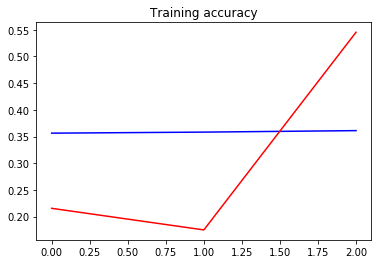

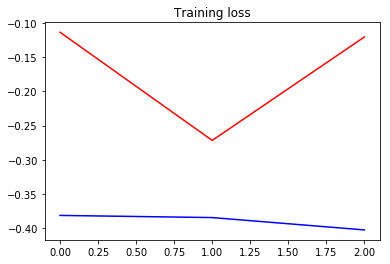

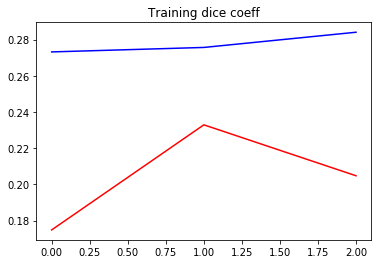

<Figure size 432x288 with 0 Axes>

In [27]:
plot_training(history)